# Load packages

In [116]:
import re
import json
from pathlib import Path
import pandas as pd
import numpy as np

In [117]:
!pwd

/storage/users/job37yv/Projects/Cardiomyopathy/scripts


# Data Loading

In [118]:
import pandas as pd

# Path to your Excel file (relative to your scripts folder)
file_path = "../data/raw_data/Johannes_Version-2-qc.xlsx"

# Load with header rows (the real header starts at row 3, so use header=2)
df_raw = pd.read_excel(file_path, sheet_name=0, header=0)

# Drop the first repeated header row
df_raw = df_raw.iloc[1:, :]

df_raw.head(30)


,Patients,"Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)",diabetes type,age,sex,Duration of Disease (months),SNAP (sural nerve),HbA1c (%),NIS-LL,SAS,NPSI,IENFD(per mm),"NF155 periodicity, mean (±SD)","NF186 periodicity, mean (±SD)","Caspr1 periodicity , mean (±SD)"
1,DB28513,1,2,66.0,male,75,0,4.9,15,32,33,1.93,413.51 (±167),413.51(±167),532.12(±157)
2,DB45913,2,2,63.0,male,11,34.3,5.3,0,2,0,3.76,542.21 (±152),542.21(±152),189.21(±81)
3,DB67312,2,2,72.0,male,180,6.3,7.8,1,0,0,1.72,NaN,NaN,231.60(±92)
4,DB85312,1,2,70.0,male,18,3.1,7,13,1,5,1.06,387.41 (±160),387.41(±160),316(±145)
5,DB6213,2,2,54.0,male,144,13.4,7.1,0,12,0,3.38,226.49 (±58),226.49 (±58),299.43(±135)
6,DB10613,1,2,69.0,male,11,2,9.8,5,10,12,0.25,311.98587 (±107),311.98587 (±107),331.21(±136)
7,DB82112,1,2,61.0,male,1,6.5,6.8,2,2,0,1.21,275.00(±100),275.00(±100),314.86 (±156)
8,DB553/13,1,2,73.0,male,180,2.8,6.8,3,17,0,2.67,420.90 (±225),420.90 (±225),331.44 (±156)
9,DB1034/13,1,2,55.0,male,0,4,"6,1",23,17,34,0,600,600,600
10,DB1091/13,1,1,54.0,male,252,8.6,7.1,25,28,49,6.52,456(±153),456(±153),511.12(±147)


# Data cleaning

In [120]:
import pandas as pd
import numpy as np
import re

# --- Load (keeping your current approach) ---
file_path = "../data/raw_data/Johannes_Version-2.xlsx"
df = pd.read_excel(file_path, sheet_name=0, header=0)
df = df.iloc[1:, :]   # drop repeated header row

# --- Replace "Not Good ..." with 500 (per your code/comment mismatch noted earlier) ---
df = df.replace(to_replace=r".*Not Good.*", value=500, regex=True)

# --- Normalize raw column names to match the "current headers changed" version you posted ---
def _norm(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()   # collapse multiple spaces
    s = re.sub(r"\s+,", ",", s)          # remove space before commas: " ," -> ","
    return s

df.columns = [_norm(c) for c in df.columns]

# For reference, the current headers you showed (after normalization) should look like:
# "Patients",
# "Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)",
# "diabetes type",
# "age",
# "sex",
# "Duration of Disease (months)",
# "SNAP (sural nerve)",
# "HbA1c (%)",
# "NIS-LL",
# "SAS",
# "NPSI",
# "IENFD(per mm)",
# "NF155 periodicity, mean (±SD)",
# "NF186 periodicity, mean (±SD)",
# "Caspr1 periodicity, mean (±SD)"

# --- Rename to shorter names (keys now match the normalized headers above) ---
df = df.rename(columns={
    "Patients": "patient_id",
    "Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)": "group",
    "diabetes type": "diabetes_type",
    "age": "age",
    "sex": "sex",
    "Duration of Disease (months)": "duration_months",
    "SNAP (sural nerve)": "snap_sural_nerve",
    "HbA1c (%)": "hba1c_pct",
    "NIS-LL": "nis_ll",
    "SAS": "sas",
    "NPSI": "npsi",
    "IENFD(per mm)": "ienfd_per_mm",
    "NF155 periodicity, mean (±SD)": "nf155_mean_nm",
    "NF186 periodicity, mean (±SD)": "nf186_mean_nm",
    "Caspr1 periodicity, mean (±SD)": "caspr1_mean_nm"
})

# --- Convert numeric-looking columns ---
numeric_cols = [
    "age", "duration_months", "snap_sural_nerve",
    "hba1c_pct", "nis_ll", "sas", "npsi", "ienfd_per_mm",
    "nf155_mean_nm", "nf186_mean_nm", "caspr1_mean_nm"
]

def to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).replace(",", ".").strip()
    # take the first token before space/parenthesis (handles "413.51 (±167)")
    s = s.split(" ")[0].split("(")[0]
    try:
        return float(s)
    except:
        return np.nan

for col in numeric_cols:
    if col in df.columns:  # guard in case any column is missing
        df[col] = df[col].apply(to_float)

# --- Binary encoding for sex ---
def clean_sex(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if s.startswith("m"): return 1
    if s.startswith("f"): return 0
    return np.nan

if "sex" in df.columns:
    df["sex"] = df["sex"].map(clean_sex)

# --- Drop rows with more than 3 NaNs ---
df = df[df.isna().sum(axis=1) <= 3].reset_index(drop=True)

# --- One-hot encode categorical variables (if present) ---
cats = [c for c in ["group", "diabetes_type"] if c in df.columns]
df_encoded = pd.get_dummies(df, columns=cats, drop_first=True) if cats else df.copy()

print("Cols after rename:", list(df.columns))
print("Shape after cleaning:", df.shape)
print("Shape after encoding:", df_encoded.shape)

df.head(20)

Cols after rename: ['patient_id', 'group', 'diabetes_type', 'age', 'sex', 'duration_months', 'snap_sural_nerve', 'hba1c_pct', 'nis_ll', 'sas', 'npsi', 'ienfd_per_mm', 'nf155_mean_nm', 'nf186_mean_nm', 'caspr1_mean_nm']
Shape after cleaning: (35, 15)
Shape after encoding: (35, 17)


,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.9,15.0,32.0,33.0,1.93,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.3,0.0,2.0,0.0,3.76,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.8,1.0,0.0,0.0,1.72,NaN,NaN,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.0,13.0,1.0,5.0,1.06,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.1,0.0,12.0,0.0,3.38,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.8,5.0,10.0,12.0,0.25,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.8,2.0,2.0,0.0,1.21,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.8,3.0,17.0,0.0,2.67,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.1,23.0,17.0,34.0,0.00,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.1,25.0,28.0,49.0,6.52,456.00000,456.00000,511.12


## Impute NaN

In [121]:
# Function to impute missing periodicity values from the other two
def impute_from_others(row, target, others):
    if pd.isna(row[target]):
        for col in others:
            if not pd.isna(row[col]):
                return row[col]
    return row[target]

periodicity_cols = ["nf155_mean_nm", "nf186_mean_nm", "caspr1_mean_nm"]

for col in periodicity_cols:
    others = [c for c in periodicity_cols if c != col]
    df[col] = df.apply(lambda row: impute_from_others(row, col, others), axis=1)


In [122]:
df.head(30)

,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.9,15.0,32.0,33.0,1.93,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.3,0.0,2.0,0.0,3.76,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.8,1.0,0.0,0.0,1.72,231.60000,231.60000,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.0,13.0,1.0,5.0,1.06,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.1,0.0,12.0,0.0,3.38,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.8,5.0,10.0,12.0,0.25,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.8,2.0,2.0,0.0,1.21,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.8,3.0,17.0,0.0,2.67,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.1,23.0,17.0,34.0,0.00,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.1,25.0,28.0,49.0,6.52,456.00000,456.00000,511.12


In [123]:
df.head(38)

,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.9,15.0,32.0,33.0,1.93,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.3,0.0,2.0,0.0,3.76,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.8,1.0,0.0,0.0,1.72,231.60000,231.60000,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.0,13.0,1.0,5.0,1.06,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.1,0.0,12.0,0.0,3.38,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.8,5.0,10.0,12.0,0.25,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.8,2.0,2.0,0.0,1.21,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.8,3.0,17.0,0.0,2.67,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.1,23.0,17.0,34.0,0.00,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.1,25.0,28.0,49.0,6.52,456.00000,456.00000,511.12


In [124]:
# Fill NaNs in selected columns with the lower quartile (Q1 = 0.25) of each column
cols_to_impute = ["snap_sural_nerve", "hba1c_pct", "ienfd_per_mm"]
q = 0.25  # lower quartile

impute_vals = {}
for col in cols_to_impute:
    if col in df.columns:
        qval = df[col].quantile(q, interpolation="linear")
        # Only fill if we actually have a numeric quantile (not all-NaN column)
        if pd.notna(qval):
            df[col] = df[col].fillna(qval)
            impute_vals[col] = qval

print("Imputation values (Q1):", impute_vals)
print("Remaining NaNs in target cols:", df[cols_to_impute].isna().sum().to_dict())

df.head(38)

Imputation values (Q1): {'snap_sural_nerve': np.float64(2.4), 'hba1c_pct': np.float64(6.125), 'ienfd_per_mm': np.float64(1.3375)}
Remaining NaNs in target cols: {'snap_sural_nerve': 0, 'hba1c_pct': 0, 'ienfd_per_mm': 0}


,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.900,15.0,32.0,33.0,1.9300,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.300,0.0,2.0,0.0,3.7600,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.800,1.0,0.0,0.0,1.7200,231.60000,231.60000,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.000,13.0,1.0,5.0,1.0600,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.100,0.0,12.0,0.0,3.3800,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.800,5.0,10.0,12.0,0.2500,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.800,2.0,2.0,0.0,1.2100,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.800,3.0,17.0,0.0,2.6700,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.100,23.0,17.0,34.0,0.0000,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.100,25.0,28.0,49.0,6.5200,456.00000,456.00000,511.12


# Feature anaylsis

## Setup & config

Class counts: {1: 22, 0: 13}


,feature,n0,n1,min0,max0,min1,max1,perfect_separation,near_separation_5_95
2,duration_months,13,22,0.00000,0.000,0.00,360.00,False,True
0,age,13,22,32.00000,75.000,22.00,84.00,False,False
1,sex,13,22,0.00000,1.000,0.00,1.00,False,False
3,snap_sural_nerve,13,22,2.40000,2.400,0.00,34.30,False,False
4,hba1c_pct,13,22,6.12500,6.125,4.90,9.80,False,False
5,nis_ll,13,22,0.00000,0.000,0.00,25.00,False,False
6,sas,13,22,0.00000,0.000,0.00,32.00,False,False
7,npsi,13,22,0.00000,0.000,0.00,49.00,False,False
8,nf155_mean_nm,13,19,174.72118,252.820,226.49,542.21,False,False
9,nf186_mean_nm,13,19,174.72118,252.820,226.49,542.21,False,False


,feature,n,MWU_U,MWU_p,AUC_boot,AUC_CI_lo,AUC_CI_hi,Youden_cut,sens_at_cut,spec_at_cut,MWU_q
8,nf155_mean_nm,32,4.0,0.000005,0.983192,0.935223,1.000000,253.19,0.894737,1.000000,0.000018
9,nf186_mean_nm,32,4.0,0.000005,0.983036,0.935223,1.000000,253.19,0.894737,1.000000,0.000027
2,duration_months,35,6.5,0.000002,0.977670,0.931818,1.000000,1.00,0.954545,1.000000,0.000017
10,caspr1_mean_nm,32,15.0,0.000034,0.938559,0.829960,1.000000,278.06,0.842105,1.000000,0.000075
6,sas,35,26.0,0.000023,0.910239,0.818182,0.977273,1.00,0.818182,1.000000,0.000065
5,nis_ll,35,39.0,0.000115,0.863080,0.772727,0.954545,1.00,0.727273,1.000000,0.000211
4,hba1c_pct,35,78.0,0.023716,0.724750,0.545455,0.909091,6.20,0.727273,1.000000,0.028986
0,age,35,82.0,0.038731,0.714782,0.512238,0.895105,54.00,0.909091,0.538462,0.041026
7,npsi,35,84.5,0.009919,0.705273,0.613068,0.818182,5.00,0.409091,1.000000,0.015587
3,snap_sural_nerve,35,84.5,0.037297,0.703682,0.522727,0.863636,2.80,0.636364,1.000000,0.038731


/tmp/ipykernel_837230/1820800873.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m0, m1], labels=["Control","Patient"])


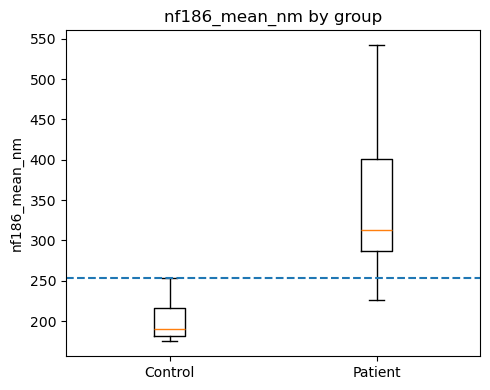

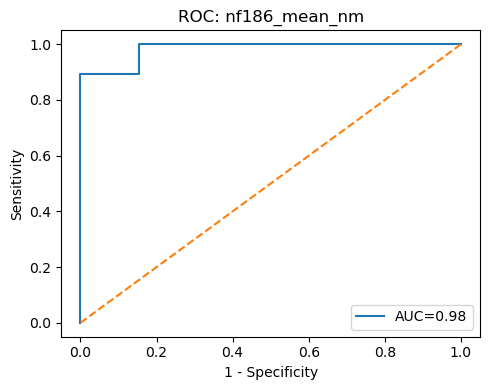

/tmp/ipykernel_837230/1820800873.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m0, m1], labels=["Control","Patient"])


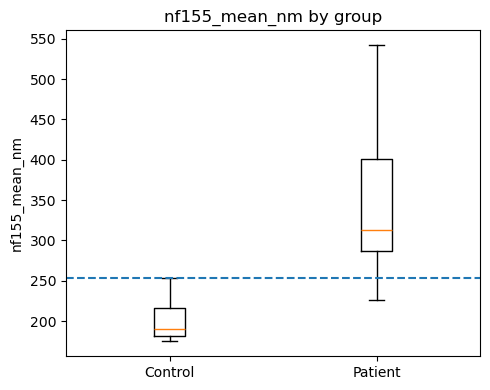

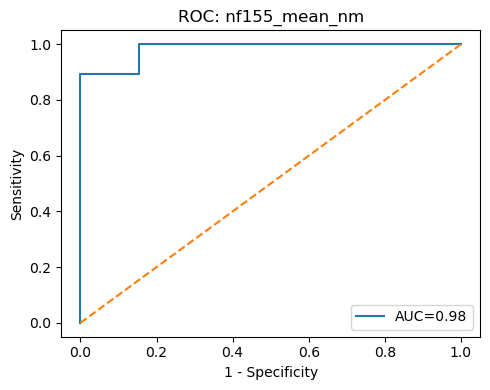

/tmp/ipykernel_837230/1820800873.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m0, m1], labels=["Control","Patient"])


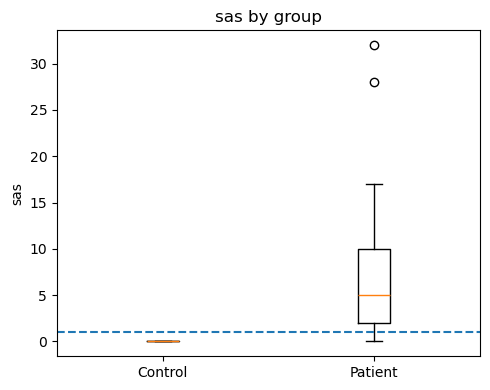

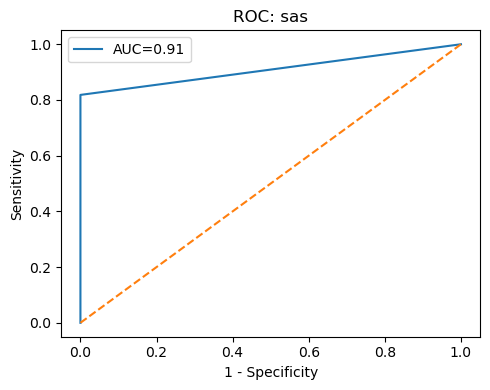

/tmp/ipykernel_837230/1820800873.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m0, m1], labels=["Control","Patient"])


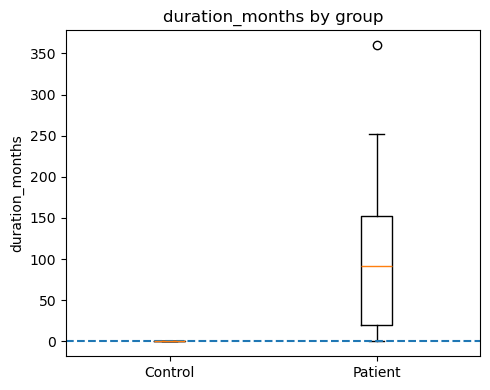

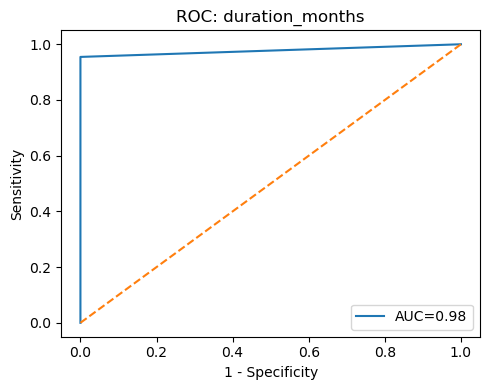

/tmp/ipykernel_837230/1820800873.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m0, m1], labels=["Control","Patient"])


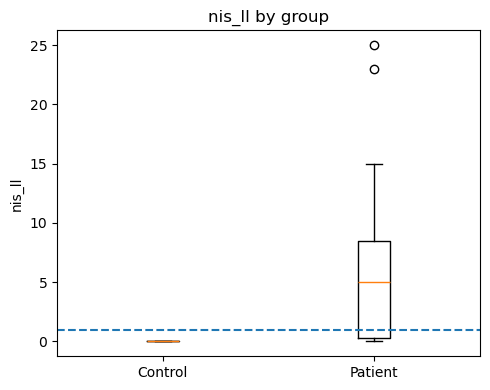

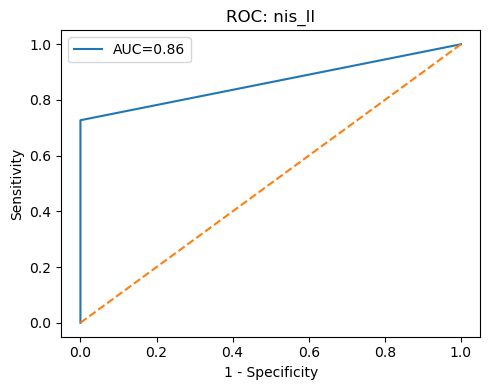

/tmp/ipykernel_837230/1820800873.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([m0, m1], labels=["Control","Patient"])


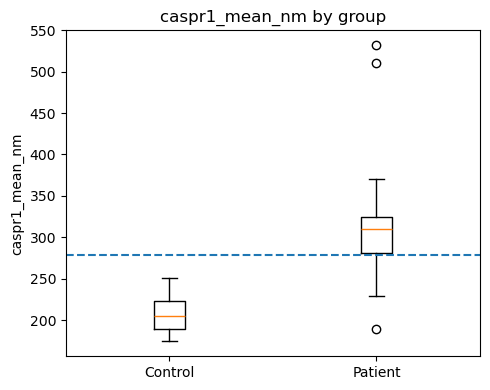

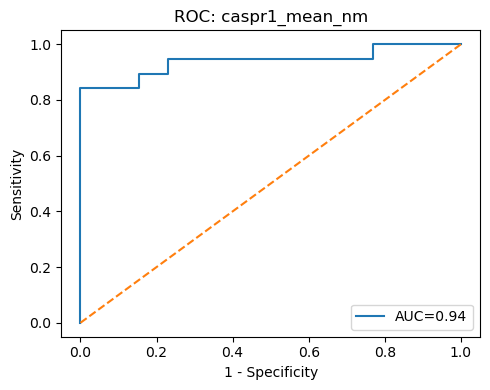

,pair,n,cut1,cut2,sens_mean,sens_lo,sens_hi,spec_mean,spec_lo,spec_hi,BA_mean,BA_lo,BA_hi,AUC_mean,AUC_lo,AUC_hi
0,duration_months OR nis_ll,35,1.0,1.00,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
2,duration_months OR sas,35,1.0,1.00,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
4,duration_months OR nf155_mean_nm,32,1.0,253.19,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
6,duration_months OR nf186_mean_nm,32,1.0,253.19,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
8,nis_ll OR nf155_mean_nm,32,1.0,253.19,0.948868,0.842105,1.0,1.0,1.0,1.0,0.974434,0.921053,1.0,0.974434,0.921053,1.0
10,nis_ll OR nf186_mean_nm,32,1.0,253.19,0.947579,0.842105,1.0,1.0,1.0,1.0,0.973789,0.921053,1.0,0.973789,0.921053,1.0
14,sas OR nf186_mean_nm,32,1.0,253.19,0.947237,0.842105,1.0,1.0,1.0,1.0,0.973618,0.921053,1.0,0.973618,0.921053,1.0
12,sas OR nf155_mean_nm,32,1.0,253.19,0.946974,0.842105,1.0,1.0,1.0,1.0,0.973487,0.921053,1.0,0.973487,0.921053,1.0
5,duration_months AND nf155_mean_nm,32,1.0,253.19,0.895974,0.736842,1.0,1.0,1.0,1.0,0.947987,0.868421,1.0,1.000000,1.000000,1.0
7,duration_months AND nf186_mean_nm,32,1.0,253.19,0.891684,0.736842,1.0,1.0,1.0,1.0,0.945842,0.868421,1.0,1.000000,1.000000,1.0


,features,AUC_boot,AUC_CI_lo,AUC_CI_hi
1,"nf155_mean_nm,duration_months",1.000000,1.000000,1.0
4,"nf186_mean_nm,duration_months",1.000000,1.000000,1.0
7,"duration_months,caspr1_mean_nm",1.000000,1.000000,1.0
5,"nf186_mean_nm,caspr1_mean_nm",0.995457,0.983755,1.0
2,"nf155_mean_nm,caspr1_mean_nm",0.995397,0.983806,1.0
3,"nf155_mean_nm,sas",0.993702,0.975709,1.0
6,"nf186_mean_nm,sas",0.993593,0.975709,1.0
0,"nf155_mean_nm,nf186_mean_nm",0.991751,0.975709,1.0
9,"caspr1_mean_nm,sas",0.988466,0.951417,1.0
8,"duration_months,sas",0.982341,0.954545,1.0



=== Tiny tree rules (depth<=2) ===
Features: ['nf155_mean_nm', 'duration_months']
|--- duration_months <= 0.500
|   |--- class: 0
|--- duration_months >  0.500
|   |--- class: 1



,microscopy,feature,n,rho,p,q
0,caspr1_mean_nm,sas,32,0.776888,1.712524e-07,0.000004
1,caspr1_mean_nm,duration_months,32,0.738310,1.410998e-06,0.000008
2,caspr1_mean_nm,nis_ll,32,0.678048,2.007552e-05,0.000054
3,caspr1_mean_nm,npsi,32,0.638611,8.381728e-05,0.000201
4,caspr1_mean_nm,sex,32,0.425320,1.523485e-02,0.028126
5,caspr1_mean_nm,hba1c_pct,32,0.398004,2.407093e-02,0.041264
6,caspr1_mean_nm,age,32,0.369107,3.762079e-02,0.060193
7,caspr1_mean_nm,snap_sural_nerve,32,0.101888,5.789739e-01,0.578974
8,nf155_mean_nm,sas,32,0.760234,4.464197e-07,0.000004
9,nf155_mean_nm,duration_months,32,0.715914,4.092256e-06,0.000014


In [137]:
# =========================================
# 0) Imports & config
# =========================================
from pathlib import Path
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, spearmanr

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import LeaveOneOut

# ---- Paths / constants
OUT = Path("../analysis/diagnostics_nonparametric")
(OUT / "figs").mkdir(parents=True, exist_ok=True)

RNG = np.random.default_rng(42)
B = 2000                      # bootstrap resamples
MIN_SAMPLES = 8               # minimum usable samples for any analysis
MAX_K_FOR_COMBOS = 2          # we’ll keep combos simple (2-feature rules)

# ---- Columns (edit if your names differ)
ID_COL = "patient_id"
GROUP_COL = "group"           # 0=control, 1=neuropathy, 2=diabetes only
CLINICAL = ["age","sex","duration_months","snap_sural_nerve","hba1c_pct"]
QUESTION = ["nis_ll","sas","npsi"]
MICRO = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]
ALL_FEATURES = CLINICAL + QUESTION + MICRO

# =========================================
# 1) Label: HEALTH vs PATIENT (+ light cleaning)
# =========================================
df = df.copy()

# Treat obvious instrument caps for microscopy as missing (adjust if needed)
for c in MICRO:
    if c in df.columns:
        df.loc[df[c] >= 600, c] = np.nan

# Define binary label (0=HEALTH/control, 1=PATIENT=group 1 or 2)
if GROUP_COL in df.columns:
    df["is_patient"] = df[GROUP_COL].map({0:0, 1:1, 2:1})
else:
    # fallback via ID prefix (HC=control)
    df["is_patient"] = df[ID_COL].astype(str).str.startswith("HC").map({True:0, False:1}).astype(int)

print("Class counts:", df["is_patient"].value_counts(dropna=False).to_dict())

# =========================================
# 2) Leak / separability checks
#    (flags features that perfectly or near-perfectly separate the classes)
# =========================================
leak_rows = []
for f in ALL_FEATURES:
    if f not in df.columns: 
        continue
    m0 = df.loc[df["is_patient"]==0, f].dropna()
    m1 = df.loc[df["is_patient"]==1, f].dropna()
    if len(m0) >= 2 and len(m1) >= 2:
        sep = (m1.min() > m0.max()) or (m0.min() > m1.max())
        near_sep = (np.quantile(m1, 0.05) > np.quantile(m0, 0.95)) or (np.quantile(m0, 0.05) > np.quantile(m1, 0.95))
        leak_rows.append({
            "feature": f, "n0": len(m0), "n1": len(m1),
            "min0": float(m0.min()) if len(m0) else np.nan,
            "max0": float(m0.max()) if len(m0) else np.nan,
            "min1": float(m1.min()) if len(m1) else np.nan,
            "max1": float(m1.max()) if len(m1) else np.nan,
            "perfect_separation": bool(sep),
            "near_separation_5_95": bool(near_sep)
        })
leaks = pd.DataFrame(leak_rows).sort_values(["perfect_separation","near_separation_5_95"], ascending=False)
leaks.to_csv(OUT/"leak_check.csv", index=False)
display(leaks.head(10))

# =========================================
# 3) Univariate nonparametric diagnostics (HEALTH vs PATIENT)
#    - Mann–Whitney U (≡ AUC test)
#    - stratified bootstrap AUC 95% CI
#    - Youden J cutoff + sens/spec
# =========================================
def stratified_boot_auc(y, x, B=2000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = np.asarray(y, int)
    x = np.asarray(x, float)
    idx0 = np.where(y==0)[0]
    idx1 = np.where(y==1)[0]
    if len(idx0)==0 or len(idx1)==0:
        return np.nan, (np.nan, np.nan)
    aucs = []
    for _ in range(B):
        s0 = rng.choice(idx0, size=len(idx0), replace=True)
        s1 = rng.choice(idx1, size=len(idx1), replace=True)
        xi = np.concatenate([x[s0], x[s1]])
        yi = np.concatenate([np.zeros_like(s0), np.ones_like(s1)])
        try:
            aucs.append(roc_auc_score(yi, xi))
        except Exception:
            continue
    if not aucs:
        return np.nan, (np.nan, np.nan)
    aucs = np.array(aucs)
    return float(np.nanmean(aucs)), (float(np.nanpercentile(aucs, 2.5)),
                                     float(np.nanpercentile(aucs, 97.5)))

def youden_cut(y, x):
    y = np.asarray(y, int)
    x = np.asarray(x, float)
    if len(np.unique(y)) < 2:
        return {k: np.nan for k in ["cut","sens","spec","auc"]}
    fpr, tpr, thr = roc_curve(y, x)  # higher x = more 'patient'
    J = tpr - fpr
    j = int(np.nanargmax(J))
    return {"cut": float(thr[j]), "sens": float(tpr[j]),
            "spec": float(1 - fpr[j]), "auc": float(auc(fpr, tpr))}

def mwu_test(y, x):
    y = np.asarray(y, int)
    x = np.asarray(x, float)
    x0 = x[y==0]; x1 = x[y==1]
    if len(x0) < 2 or len(x1) < 2:
        return np.nan, np.nan
    u, p = mannwhitneyu(x0, x1, alternative="two-sided")
    # AUC = U / (n0*n1)
    return float(u), float(p)

rows = []
for f in ALL_FEATURES:
    if f not in df.columns: 
        continue
    m = df[["is_patient", f]].dropna()
    if len(m) < MIN_SAMPLES or m["is_patient"].nunique() < 2:
        continue
    y, x = m["is_patient"].astype(int).values, m[f].astype(float).values

    u, p = mwu_test(y, x)
    auc_bs, (ci_lo, ci_hi) = stratified_boot_auc(y, x, B=B, rng=RNG)
    ydn = youden_cut(y, x)

    rows.append({
        "feature": f, "n": int(len(m)),
        "MWU_U": u, "MWU_p": p,
        "AUC_boot": auc_bs, "AUC_CI_lo": ci_lo, "AUC_CI_hi": ci_hi,
        "Youden_cut": ydn["cut"], "sens_at_cut": ydn["sens"], "spec_at_cut": ydn["spec"],
    })

uni = pd.DataFrame(rows).sort_values(["AUC_boot","sens_at_cut","spec_at_cut"], ascending=False)
# FDR across all MWU p-values
if len(uni):
    pvals = uni["MWU_p"].values
    order = np.argsort(pvals); ranked = np.empty_like(order); ranked[order] = np.arange(1, len(pvals)+1)
    q = pvals * len(pvals) / ranked
    q_sorted = np.minimum.accumulate(np.flip(np.sort(q))); q_adj = np.empty_like(q); q_adj[order] = np.flip(q_sorted)
    uni["MWU_q"] = np.clip(q_adj, 0, 1)

display(uni)
uni.to_csv(OUT/"univariate_HEALTH_vs_PATIENT.csv", index=False)

# =========================================
# 4) Plots for top features (distribution + ROC)
# =========================================
def plot_box_with_cut(feat, cut=None):
    m0 = df.loc[df["is_patient"]==0, feat].dropna()
    m1 = df.loc[df["is_patient"]==1, feat].dropna()
    if len(m0)==0 or len(m1)==0: return
    plt.figure(figsize=(5,4))
    plt.boxplot([m0, m1], labels=["Control","Patient"])
    if cut is not None and np.isfinite(cut):
        plt.axhline(cut, linestyle="--")
    plt.ylabel(feat); plt.title(f"{feat} by group")
    plt.tight_layout(); plt.savefig(OUT/"figs"/f"box_{feat}.png", dpi=300); plt.show()

def plot_roc(feat):
    m = df[["is_patient", feat]].dropna()
    if m["is_patient"].nunique() < 2: return
    y = m["is_patient"].astype(int).values
    x = m[feat].astype(float).values
    fpr, tpr, _ = roc_curve(y, x)
    val_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={val_auc:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title(f"ROC: {feat}")
    plt.legend(); plt.tight_layout(); plt.savefig(OUT/"figs"/f"roc_{feat}.png", dpi=300); plt.show()

top_feats = uni.head(6)["feature"].tolist() if len(uni) else []
for f in set(top_feats + MICRO):
    if f in uni["feature"].values:
        cut = float(uni.loc[uni["feature"]==f, "Youden_cut"].values[0])
    else:
        cut = None
    if f in df.columns:
        plot_box_with_cut(f, cut)
        plot_roc(f)

# =========================================
# 5) Simple 2-feature rules (cut1 +/- cut2, AND/OR), with bootstrap
# =========================================
def rule_score(y, x1, c1, x2, c2, op="OR"):
    # patient if (x1>=c1) OR/AND (x2>=c2)
    pred = ((x1 >= c1) | (x2 >= c2)) if op=="OR" else ((x1 >= c1) & (x2 >= c2))
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    sens = tp/(tp+fn) if (tp+fn) else np.nan
    spec = tn/(tn+fp) if (tn+fp) else np.nan
    ba = (sens + spec) / 2 if np.isfinite(sens) and np.isfinite(spec) else np.nan
    try:
        rocAUC = roc_auc_score(y, ((x1-c1)>=0).astype(int) + ((x2-c2)>=0).astype(int))
    except Exception:
        rocAUC = np.nan
    return sens, spec, ba, rocAUC

def bootstrap_rule(y, x1, c1, x2, c2, op="OR", B=2000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = np.asarray(y, int); x1 = np.asarray(x1, float); x2 = np.asarray(x2, float)
    idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
    if len(idx0)==0 or len(idx1)==0: return (np.nan,)*8
    sens, spec, ba, aucs = [], [], [], []
    for _ in range(B):
        s0 = rng.choice(idx0, len(idx0), True)
        s1 = rng.choice(idx1, len(idx1), True)
        xi1 = np.concatenate([x1[s0], x1[s1]])
        xi2 = np.concatenate([x2[s0], x2[s1]])
        yi  = np.concatenate([np.zeros_like(s0), np.ones_like(s1)])
        s, p, b, a = rule_score(yi, xi1, c1, xi2, c2, op=op)
        sens.append(s); spec.append(p); ba.append(b); aucs.append(a)
    def ci(v): 
        v = np.array(v, float)
        return float(np.nanmean(v)), float(np.nanpercentile(v,2.5)), float(np.nanpercentile(v,97.5))
    return (*ci(sens), *ci(spec), *ci(ba), *ci(aucs))

# choose top univariate from each family for pairing
pick = {
    "clinical": [f for f in CLINICAL if f in top_feats][:2],
    "question": [f for f in QUESTION if f in top_feats][:2],
    "micro":    [f for f in MICRO if f in top_feats][:2],
}
# fill if empty
for k, pool in pick.items():
    if not pool:
        # take best available from that family by AUC
        fam = CLINICAL if k=="clinical" else QUESTION if k=="question" else MICRO
        fam_in = [f for f in fam if f in uni["feature"].values]
        fam_sorted = uni.set_index("feature").loc[fam_in].sort_values("AUC_boot", ascending=False).index.tolist()
        pick[k] = fam_sorted[:2]

pair_rows = []
for famA, famB in [("clinical","question"),("clinical","micro"),("question","micro")]:
    for f1 in pick[famA]:
        for f2 in pick[famB]:
            m = df[[f1,f2,"is_patient"]].dropna()
            if len(m) < MIN_SAMPLES: 
                continue
            y = m["is_patient"].astype(int).values
            x1 = m[f1].astype(float).values
            x2 = m[f2].astype(float).values
            # Youden cuts per feature
            c1 = youden_cut(y, x1)["cut"]
            c2 = youden_cut(y, x2)["cut"]
            for op in ["OR","AND"]:
                s_mean,s_lo,s_hi, p_mean,p_lo,p_hi, b_mean,b_lo,b_hi, a_mean,a_lo,a_hi = bootstrap_rule(
                    y, x1, c1, x2, c2, op=op, B=B, rng=RNG
                )
                pair_rows.append({
                    "pair": f"{f1} {op} {f2}", "n": len(m),
                    "cut1": c1, "cut2": c2,
                    "sens_mean": s_mean, "sens_lo": s_lo, "sens_hi": s_hi,
                    "spec_mean": p_mean, "spec_lo": p_lo, "spec_hi": p_hi,
                    "BA_mean": b_mean, "BA_lo": b_lo, "BA_hi": b_hi,
                    "AUC_mean": a_mean, "AUC_lo": a_lo, "AUC_hi": a_hi
                })
pairs = pd.DataFrame(pair_rows).sort_values(["BA_mean","AUC_mean"], ascending=False)
display(pairs.head(10))
pairs.to_csv(OUT/"two_feature_rules_bootstrap.csv", index=False)

# =========================================
# 6) (Optional) Tiny decision tree (depth<=2) with bootstrap perf
# =========================================
def bootstrap_tree_perf(df, feats, B=1000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    m = df[["is_patient"]+feats].dropna()
    if len(m) < MIN_SAMPLES: return np.nan, (np.nan,np.nan)
    y = m["is_patient"].astype(int).values
    X = m[feats].astype(float).values
    idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
    aucs = []
    for _ in range(B):
        s0 = rng.choice(idx0, len(idx0), True)
        s1 = rng.choice(idx1, len(idx1), True)
        Xi = np.concatenate([X[s0], X[s1]], axis=0)
        yi = np.concatenate([np.zeros_like(s0), np.ones_like(s1)])
        clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, random_state=42).fit(Xi, yi)
        # evaluate on out-of-bag? We’ll use .predict_proba on Xi_boot itself (bootstrap .632 will average optimism out)
        try:
            p = clf.predict_proba(Xi)[:,1]; aucs.append(roc_auc_score(yi, p))
        except Exception:
            aucs.append(np.nan)
    aucs = np.array(aucs, float)
    return float(np.nanmean(aucs)), (float(np.nanpercentile(aucs,2.5)), float(np.nanpercentile(aucs,97.5)))

# try a small set based on univariate top
tree_candidates = uni.head(5)["feature"].tolist() if len(uni) else []
tree_rows = []
for feats in it.combinations(tree_candidates, 2):
    mean_auc, (ci_lo, ci_hi) = bootstrap_tree_perf(df, list(feats), B=1000, rng=RNG)
    tree_rows.append({"features": ",".join(feats), "AUC_boot": mean_auc, "AUC_CI_lo": ci_lo, "AUC_CI_hi": ci_hi})
trees = pd.DataFrame(tree_rows).sort_values("AUC_boot", ascending=False)
display(trees.head(10))
trees.to_csv(OUT/"tiny_tree_pairs_bootstrap.csv", index=False)

# Fit and print rules for the best pair (depth=2) on all available rows
if len(trees):
    best_feats = trees.iloc[0]["features"].split(",")
    m = df[["is_patient"]+best_feats].dropna()
    Xf = m[best_feats].astype(float).values
    yf = m["is_patient"].astype(int).values
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, random_state=42).fit(Xf, yf)
    rules = export_text(tree, feature_names=best_feats, decimals=3)
    print("\n=== Tiny tree rules (depth<=2) ===")
    print(f"Features: {best_feats}\n{rules}")
    with open(OUT/"tiny_tree_best_rules.txt","w") as f:
        f.write(rules)

# =========================================
# 7) Microscopy vs clinical/questionnaire: Spearman + FDR
# =========================================
def fdr_bh(pvals):
    p = np.array(pvals, float)
    n = len(p)
    order = np.argsort(p)
    ranks = np.empty_like(order); ranks[order] = np.arange(1, n+1)
    q = p * n / ranks
    q_sorted = np.minimum.accumulate(np.flip(np.sort(q)))
    q_adj = np.empty_like(q); q_adj[order] = np.flip(q_sorted)
    return np.clip(q_adj, 0, 1)

corr_rows = []
OTHERS = [f for f in CLINICAL + QUESTION if f in df.columns]
for t in [c for c in MICRO if c in df.columns]:
    for f in OTHERS:
        m = df[[t,f]].dropna()
        if len(m) < MIN_SAMPLES: 
            continue
        r, pval = spearmanr(m[t], m[f])
        corr_rows.append({"microscopy": t, "feature": f, "n": int(len(m)), "rho": float(r), "p": float(pval)})

corr = pd.DataFrame(corr_rows)
if len(corr):
    corr["q"] = fdr_bh(corr["p"])
    corr = corr.sort_values(["microscopy","q","p"]).reset_index(drop=True)
    display(corr.head(20))
    corr.to_csv(OUT/"spearman_microscopy_vs_clinical_question.csv", index=False)


# “How early” can microscopy diagnose?

Counts: {1: 22, 0: 13}


,family,feature,n,AUC_boot,AUC_lo,AUC_hi,cut_youden,sens_at_cut,spec_at_cut
0,Microscopy,nf155_mean_nm,32,0.987854,0.939271,1.000000,253.19,0.894737,1.000000
1,Microscopy,nf186_mean_nm,32,0.987854,0.939271,1.000000,253.19,0.894737,1.000000
2,Microscopy,caspr1_mean_nm,32,0.947368,0.838057,1.000000,278.06,0.842105,1.000000
3,Questionnaire,sas,35,0.909091,0.818182,0.977273,1.00,0.818182,1.000000
4,Questionnaire,nis_ll,35,0.863636,0.772727,0.954545,1.00,0.727273,1.000000
5,Clinical,hba1c_pct,35,0.727273,0.545455,0.909091,6.20,0.727273,1.000000
6,Clinical,age,35,0.716783,0.517439,0.884615,54.00,0.909091,0.538462
7,Questionnaire,npsi,35,0.704545,0.613636,0.818182,5.00,0.409091,1.000000
8,Clinical,snap_sural_nerve,35,0.704545,0.522727,0.863636,2.80,0.636364,1.000000
9,Clinical,sex,35,0.701049,0.547203,0.846154,1.00,0.863636,0.538462


,features,n,sens,spec,BA,op
42,snap_sural_nerve OR nf155_mean_nm,32,1.000000,1.0,1.000000,OR
44,snap_sural_nerve OR nf186_mean_nm,32,1.000000,1.0,1.000000,OR
46,snap_sural_nerve OR caspr1_mean_nm,32,1.000000,1.0,1.000000,OR
50,hba1c_pct OR sas,35,1.000000,1.0,1.000000,OR
54,hba1c_pct OR nf155_mean_nm,32,1.000000,1.0,1.000000,OR
56,hba1c_pct OR nf186_mean_nm,32,1.000000,1.0,1.000000,OR
36,snap_sural_nerve OR nis_ll,35,0.954545,1.0,0.977273,OR
64,nis_ll OR nf155_mean_nm,32,0.947368,1.0,0.973684,OR
66,nis_ll OR nf186_mean_nm,32,0.947368,1.0,0.973684,OR
68,nis_ll OR caspr1_mean_nm,32,0.947368,1.0,0.973684,OR



Decision tree (depth≤2) using top OR-pair:
|--- nf155_mean_nm <= 253.005
|   |--- nf155_mean_nm <= 224.475
|   |   |--- class: 0
|   |--- nf155_mean_nm >  224.475
|   |   |--- class: 0
|--- nf155_mean_nm >  253.005
|   |--- class: 1



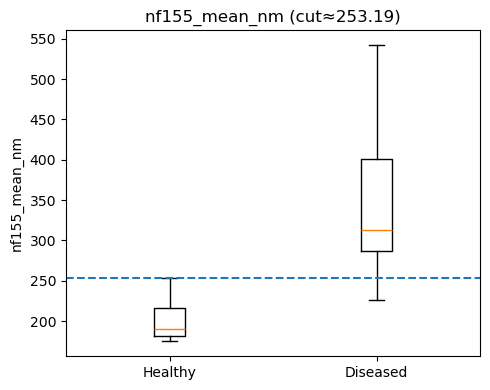

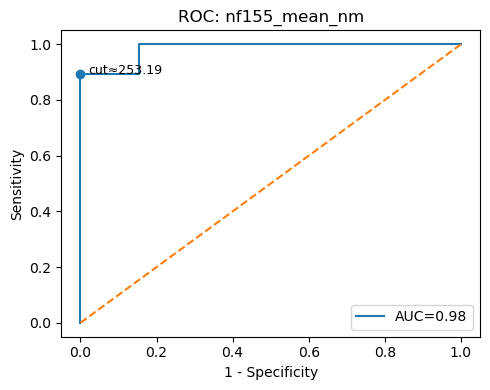

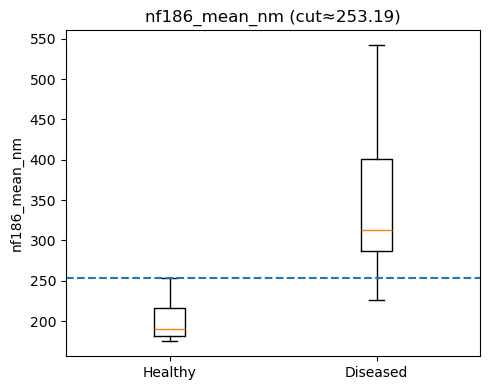

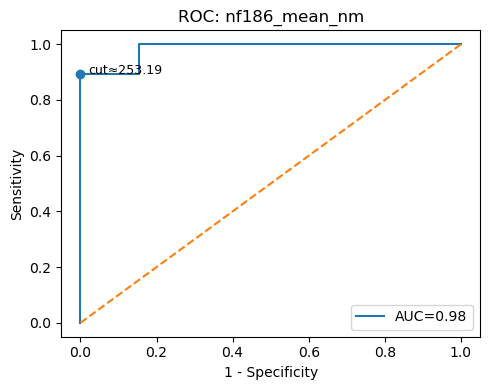

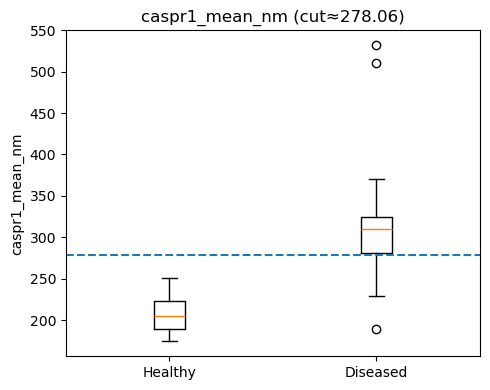

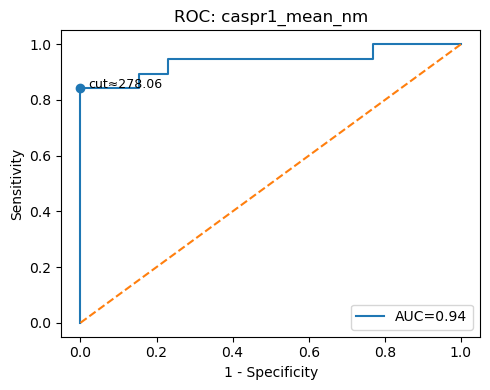

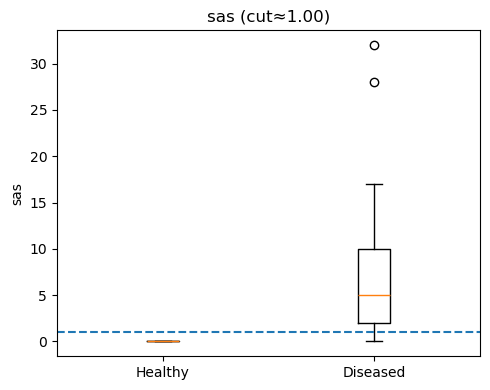

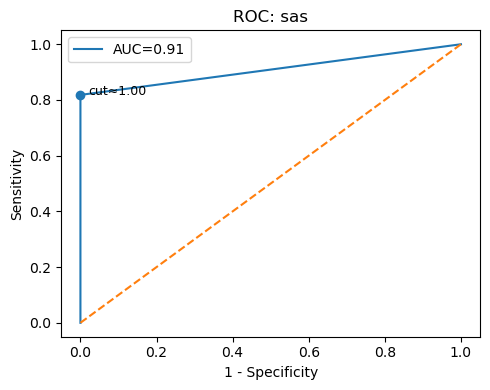

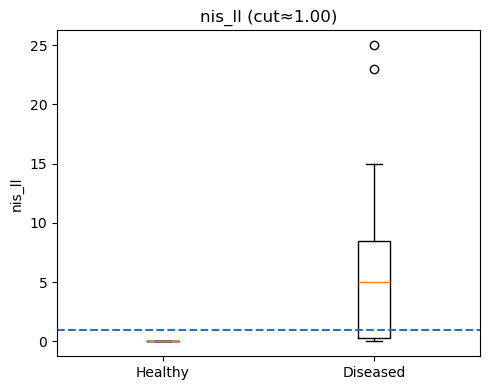

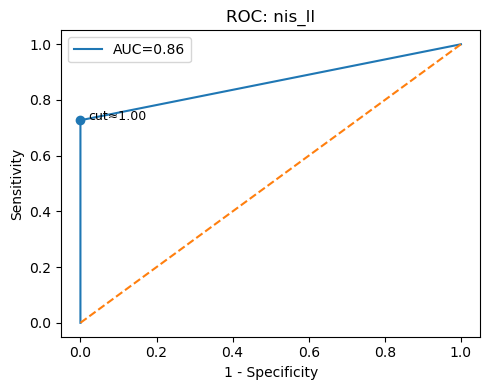


Saved to: /storage/users/job37yv/Projects/Cardiomyopathy/analysis/final-healthy-vs-diseased


In [146]:
from pathlib import Path
import numpy as np, pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier, export_text

OUT = Path("../analysis/final-healthy-vs-diseased")
(OUT/"figs").mkdir(parents=True, exist_ok=True)
RNG = np.random.default_rng(42)
B = 2000
MIN_SAMPLES = 8

CLINICAL = ["age","sex","snap_sural_nerve","hba1c_pct"]
QUESTION = ["nis_ll","sas","npsi"]
MICRO    = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]
FAMS = {"Microscopy": MICRO, "Questionnaire": QUESTION, "Clinical": CLINICAL}

# Label: healthy (0) vs diseased (1 or 2)
df_h = df.copy()
df_h["is_patient"] = df_h["group"].map({0:0, 1:1, 2:1})
print("Counts:", df_h["is_patient"].value_counts().to_dict())

# Treat instrument caps as missing
for c in MICRO:
    if c in df_h.columns:
        df_h.loc[df_h[c] >= 600, c] = np.nan

def boot_auc(y, x, B=2000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = np.asarray(y, int); x = np.asarray(x, float)
    i0, i1 = np.where(y==0)[0], np.where(y==1)[0]
    if len(i0)==0 or len(i1)==0: return np.nan, (np.nan, np.nan)
    vals = []
    for _ in range(B):
        s0 = rng.choice(i0, len(i0), True)
        s1 = rng.choice(i1, len(i1), True)
        xi = np.concatenate([x[s0], x[s1]])
        yi = np.concatenate([np.zeros_like(s0), np.ones_like(s1)])
        try: vals.append(roc_auc_score(yi, xi))
        except: vals.append(np.nan)
    vals = np.array(vals, float)
    return float(np.nanmedian(vals)), (float(np.nanpercentile(vals,2.5)), float(np.nanpercentile(vals,97.5)))

def youden(y, x):
    y = np.asarray(y, int); x = np.asarray(x, float)
    if np.unique(y).size < 2: return None
    fpr, tpr, thr = roc_curve(y, x)
    j = int(np.nanargmax(tpr - fpr))
    return dict(cut=float(thr[j]), sens=float(tpr[j]), spec=float(1-fpr[j]), auc=float(auc(fpr,tpr)))

# --------- Table 1: single-feature performance ---------
rows = []
for fam, feats in FAMS.items():
    for f in feats:
        if f not in df_h.columns: continue
        m = df_h[["is_patient", f]].dropna()
        if len(m) < MIN_SAMPLES or m["is_patient"].nunique()<2: continue
        y = m["is_patient"].astype(int).values
        x = m[f].astype(float).values
        u, p = mannwhitneyu(x[y==0], x[y==1], alternative="two-sided") if (sum(y==0)>=2 and sum(y==1)>=2) else (np.nan, np.nan)
        auc_med, (lo, hi) = boot_auc(y, x, B=B, rng=RNG)
        ydn = youden(y, x)
        rows.append({
            "family": fam, "feature": f, "n": len(m),
            "AUC_boot": auc_med, "AUC_lo": lo, "AUC_hi": hi,
            "cut_youden": ydn["cut"] if ydn else np.nan,
            "sens_at_cut": ydn["sens"] if ydn else np.nan,
            "spec_at_cut": ydn["spec"] if ydn else np.nan
        })
uni = pd.DataFrame(rows).sort_values(["AUC_boot"], ascending=False).reset_index(drop=True)
display(uni)
uni.to_csv(OUT/"table_single_feature.csv", index=False)

# --------- Table 2: best pair rules (exclude duration) ---------
def rule_eval(y, s1, c1, s2, c2, op="OR"):
    pred = ((s1>=c1) | (s2>=c2)) if op=="OR" else ((s1>=c1) & (s2>=c2))
    tn, fp, fn, tp = pd.crosstab(pd.Series(y, name="y"), pd.Series(pred, name="pred")).reindex(index=[0,1], columns=[0,1], fill_value=0).values.ravel()
    sens = tp/(tp+fn) if (tp+fn) else np.nan
    spec = tn/(tn+fp) if (tn+fp) else np.nan
    ba = (sens+spec)/2 if np.isfinite(sens) and np.isfinite(spec) else np.nan
    return sens, spec, ba

pairs = []
cand = CLINICAL + QUESTION + MICRO
for f1, f2 in it.combinations(cand, 2):
    m = df_h[["is_patient", f1, f2]].dropna()
    if len(m) < MIN_SAMPLES or m["is_patient"].nunique()<2: continue
    y = m["is_patient"].astype(int).values
    x1 = m[f1].astype(float).values
    x2 = m[f2].astype(float).values
    c1 = youden(y, x1)["cut"]; c2 = youden(y, x2)["cut"]
    s_or, p_or, ba_or = rule_eval(y, x1, c1, x2, c2, op="OR")
    s_and, p_and, ba_and = rule_eval(y, x1, c1, x2, c2, op="AND")
    pairs.append({"features": f"{f1} OR {f2}", "n": len(m), "sens": s_or, "spec": p_or, "BA": ba_or, "op":"OR"})
    pairs.append({"features": f"{f1} AND {f2}", "n": len(m), "sens": s_and, "spec": p_and, "BA": ba_and, "op":"AND"})
pairs_df = pd.DataFrame(pairs).sort_values(["BA","spec","sens"], ascending=False)
display(pairs_df.head(15))
pairs_df.to_csv(OUT/"table_pair_rules.csv", index=False)

# --------- Tiny decision tree (max_depth=2) ---------
best_pair = pairs_df[pairs_df["op"]=="OR"].head(1)
if len(best_pair):
    f1, f2 = best_pair.iloc[0]["features"].split(" OR ")
    m = df_h[["is_patient", f1, f2]].dropna()
    X = m[[f1,f2]].astype(float).values
    y = m["is_patient"].astype(int).values
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, random_state=42).fit(X, y)
    print("\nDecision tree (depth≤2) using top OR-pair:")
    print(export_text(tree, feature_names=[f1,f2], decimals=3))
    with open(OUT/"decision_tree_rules.txt","w") as f:
        f.write(export_text(tree, feature_names=[f1,f2], decimals=3))

# --------- Plots for NF155, NF186, Caspr1, SAS, NIS-LL with cut lines ---------
def box_and_roc(feat):
    m = df_h[["is_patient", feat]].dropna()
    if len(m) < MIN_SAMPLES or m["is_patient"].nunique()<2: return
    y = m["is_patient"].astype(int).values
    x = m[feat].astype(float).values
    cut = youden(y, x)["cut"]
    # Box
    plt.figure(figsize=(5,4))
    plt.boxplot([x[y==0], x[y==1]], tick_labels=["Healthy","Diseased"])
    plt.axhline(cut, linestyle="--")
    plt.ylabel(feat); plt.title(f"{feat} (cut≈{cut:.2f})"); plt.tight_layout()
    plt.savefig(OUT/"figs"/f"box_{feat}.png", dpi=300); plt.show()
    # ROC
    fpr, tpr, thr = roc_curve(y, x)
    va = auc(fpr, tpr)
    i = int(np.argmin(np.abs(thr - cut)))
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={va:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.scatter([fpr[i]], [tpr[i]])
    plt.text(fpr[i]+0.02, tpr[i], f"cut≈{cut:.2f}", fontsize=9)
    plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title(f"ROC: {feat}")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUT/"figs"/f"roc_{feat}.png", dpi=300); plt.show()

for feat in ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm","sas","nis_ll"]:
    if feat in df_h.columns: box_and_roc(feat)

print(f"\nSaved to: {OUT.resolve()}")


### Drop-in code to quantify the “rescued by microscopy” effect + optimism-corrected metrics

In [150]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
RNG = np.random.default_rng(42)
B = 2000

# --- Use the individuals with both SAS and NF155 available
m = df[["group","sas","nf155_mean_nm"]].copy()
m = m.replace({np.inf: np.nan, -np.inf: np.nan}).dropna()
m["is_patient"] = m["group"].map({0:0,1:1,2:1}).astype(int)

# Cutoffs (from your table)
cut_sas = 1.0
cut_nf155 = 253.19

# Binarize tests
m["SAS_pos"]   = (m["sas"] >= cut_sas).astype(int)
m["NF155_pos"] = (m["nf155_mean_nm"] >= cut_nf155).astype(int)
m["OR_pos"]    = ((m["SAS_pos"]==1) | (m["NF155_pos"]==1)).astype(int)

# Confusion for SAS and OR rule
def perf(y, pred):
    y = y.values; pred = pred.values
    tn = np.sum((y==0)&(pred==0)); fp = np.sum((y==0)&(pred==1))
    fn = np.sum((y==1)&(pred==0)); tp = np.sum((y==1)&(pred==1))
    sens = tp/(tp+fn) if (tp+fn) else np.nan
    spec = tn/(tn+fp) if (tn+fp) else np.nan
    return tp, fn, tn, fp, sens, spec

tp_s, fn_s, tn_s, fp_s, sens_s, spec_s = perf(m["is_patient"], m["SAS_pos"])
tp_o, fn_o, tn_o, fp_o, sens_o, spec_o = perf(m["is_patient"], m["OR_pos"])

# How many SAS-negative patients are "rescued" by NF155?
rescued = np.sum((m["is_patient"]==1) & (m["SAS_pos"]==0) & (m["NF155_pos"]==1))
sas_neg_patients = np.sum((m["is_patient"]==1) & (m["SAS_pos"]==0))
fp_nf155 = np.sum((m["is_patient"]==0) & (m["NF155_pos"]==1))  # should be 0 at your cutoff

print(f"n with both markers: {len(m)} (patients={m['is_patient'].sum()}, controls={(1-m['is_patient']).sum()})")
print(f"SAS sens/spec: {sens_s:.3f}/{spec_s:.3f}  | OR(SAS,NF155) sens/spec: {sens_o:.3f}/{spec_o:.3f}")
print(f\"Rescued (SAS− patients flagged by NF155): {rescued}/{sas_neg_patients}  | NF155 false positives: {fp_nf155}\")

# --- Optimism-corrected sens/spec via 0.632 bootstrap for the OR rule
def eval_or_rule(df_):
    y = df_["is_patient"].values
    pred = ((df_["sas"] >= cut_sas) | (df_["nf155_mean_nm"] >= cut_nf155)).astype(int).values
    tn = np.sum((y==0)&(pred==0)); fp = np.sum((y==0)&(pred==1))
    fn = np.sum((y==1)&(pred==0)); tp = np.sum((y==1)&(pred==1))
    sens = tp/(tp+fn) if (tp+fn) else np.nan
    spec = tn/(tn+fp) if (tn+fp) else np.nan
    return sens, spec

sens_out, spec_out = eval_or_rule(m)

sens_b, spec_b = [], []
idx = np.arange(len(m))
for _ in range(B):
    s = RNG.choice(idx, size=len(idx), replace=True)
    boot = m.iloc[s]
    sens_i, spec_i = eval_or_rule(boot)
    sens_b.append(sens_i); spec_b.append(spec_i)

sens_0632 = 0.368*sens_out + 0.632*np.nanmean(sens_b)
spec_0632 = 0.368*spec_out + 0.632*np.nanmean(spec_b)

print(f"Optimism-corrected (0.632) OR-rule sens/spec ≈ {sens_0632:.3f}/{spec_0632:.3f}")


SyntaxError: unexpected character after line continuation character (3639283784.py, line 39)

# Code — “clinical/questionnaire cutoffs that predict high periodicity”

In [148]:
# ==========================================================
# Clinical/Questionnaire cutoffs to predict HIGH microscopy
# ==========================================================
from pathlib import Path
import numpy as np, pandas as pd, itertools as it
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier, export_text

OUT = Path("../analysis/micro-predictors")
(OUT/"figs").mkdir(parents=True, exist_ok=True)

RNG = np.random.default_rng(42)
B = 2000
MIN_SAMPLES = 8

# Families (edit as needed)
CLINICAL = ["age","sex","duration_months","snap_sural_nerve","hba1c_pct"]
QUESTION = ["nis_ll","sas","npsi"]
PREDICTORS = CLINICAL + QUESTION

MICRO_TARGETS = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]
THRESHOLD_STRATEGY = "median"   # or ("quantile", 0.6) etc.

# Treat instrument caps as missing
dfx = df.copy()
for c in MICRO_TARGETS:
    if c in dfx.columns:
        dfx.loc[dfx[c] >= 600, c] = np.nan

def boot_auc(y, x, B=2000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = np.asarray(y, int); x = np.asarray(x, float)
    i0, i1 = np.where(y==0)[0], np.where(y==1)[0]
    if len(i0)==0 or len(i1)==0: return np.nan, (np.nan, np.nan)
    vals = []
    for _ in range(B):
        s0 = rng.choice(i0, len(i0), True)
        s1 = rng.choice(i1, len(i1), True)
        xi = np.concatenate([x[s0], x[s1]])
        yi = np.concatenate([np.zeros_like(s0), np.ones_like(s1)])
        try: vals.append(roc_auc_score(yi, xi))
        except: vals.append(np.nan)
    vals = np.array(vals, float)
    return float(np.nanmedian(vals)), (float(np.nanpercentile(vals,2.5)), float(np.nanpercentile(vals,97.5)))

def youden(y, x):
    y = np.asarray(y, int); x = np.asarray(x, float)
    if np.unique(y).size < 2: return None
    fpr, tpr, thr = roc_curve(y, x)   # larger x => more likely "high periodicity"
    j = int(np.nanargmax(tpr - fpr))
    return dict(cut=float(thr[j]), sens=float(tpr[j]), spec=float(1-fpr[j]), auc=float(auc(fpr,tpr)))

def rule_eval(y, s1, c1, s2, c2, op="OR"):
    pred = ((s1>=c1) | (s2>=c2)) if op=="OR" else ((s1>=c1) & (s2>=c2))
    y = np.asarray(y, int); pred = np.asarray(pred, int)
    tn = np.sum((y==0)&(pred==0)); fp = np.sum((y==0)&(pred==1))
    fn = np.sum((y==1)&(pred==0)); tp = np.sum((y==1)&(pred==1))
    sens = tp/(tp+fn) if (tp+fn) else np.nan
    spec = tn/(tn+fp) if (tn+fp) else np.nan
    ba = (sens+spec)/2 if (np.isfinite(sens) and np.isfinite(spec)) else np.nan
    return sens, spec, ba

for target in MICRO_TARGETS:
    if target not in dfx.columns: 
        print(f"Skip {target}: not in df"); 
        continue

    # ---------- 1) Define "high periodicity" ----------
    tvals = pd.to_numeric(dfx[target], errors="coerce")
    if THRESHOLD_STRATEGY == "median":
        thr = float(tvals.median(skipna=True))
    elif isinstance(THRESHOLD_STRATEGY, tuple) and THRESHOLD_STRATEGY[0]=="quantile":
        thr = float(tvals.quantile(THRESHOLD_STRATEGY[1]))
    else:
        thr = float(tvals.median(skipna=True))
    dfx[f"{target}_HIGH"] = (tvals >= thr).astype(float)  # 1=high, 0=low

    print(f"\n=== {target} | HIGH threshold = {thr:.3f} ===")

    # ---------- 2) Univariate predictor table ----------
    rows = []
    for f in PREDICTORS:
        if f not in dfx.columns: 
            continue
        m = dfx[[f, f"{target}_HIGH"]].dropna()
        if len(m) < MIN_SAMPLES or m[f"{target}_HIGH"].nunique()<2:
            continue
        y = m[f"{target}_HIGH"].astype(int).values
        x = pd.to_numeric(m[f], errors="coerce").values
        if np.isnan(x).all(): 
            continue

        # AUC (bootstrap) and Youden J cutoff on predictor f
        auc_med, (lo, hi) = boot_auc(y, x, B=B, rng=RNG)
        ydn = youden(y, x)
        # (optional) MWU p (rank-based difference)
        try:
            u, p = mannwhitneyu(x[y==0], x[y==1], alternative="two-sided")
        except:
            u, p = np.nan, np.nan

        rows.append({
            "predictor": f, "n": int(len(m)),
            "AUC_boot": auc_med, "AUC_lo": lo, "AUC_hi": hi,
            "cut_youden": ydn["cut"] if ydn else np.nan,
            "sens_at_cut": ydn["sens"] if ydn else np.nan,
            "spec_at_cut": ydn["spec"] if ydn else np.nan,
            "MWU_p": p
        })

    uni = pd.DataFrame(rows).sort_values(["AUC_boot","sens_at_cut","spec_at_cut"], ascending=False).reset_index(drop=True)
    display(uni.head(15))
    uni.to_csv(OUT/f"micropred_{target}.csv", index=False)

    # ---------- 3) Simple 2-feature rules among top predictors ----------
    pair_rows = []
    top_feats = uni.head(5)["predictor"].tolist()
    for f1, f2 in it.combinations(top_feats, 2):
        m = dfx[[f1, f2, f"{target}_HIGH"]].dropna()
        if len(m) < MIN_SAMPLES or m[f"{target}_HIGH"].nunique()<2:
            continue
        y = m[f"{target}_HIGH"].astype(int).values
        x1 = pd.to_numeric(m[f1], errors="coerce").values
        x2 = pd.to_numeric(m[f2], errors="coerce").values
        c1 = youden(y, x1)["cut"]; c2 = youden(y, x2)["cut"]
        s_or, p_or, ba_or = rule_eval(y, x1, c1, x2, c2, op="OR")
        s_and, p_and, ba_and = rule_eval(y, x1, c1, x2, c2, op="AND")
        pair_rows += [
            {"features": f"{f1} OR {f2}", "n": len(m), "sens": s_or, "spec": p_or, "BA": ba_or, "op":"OR"},
            {"features": f"{f1} AND {f2}", "n": len(m), "sens": s_and, "spec": p_and, "BA": ba_and, "op":"AND"},
        ]
    pairs = pd.DataFrame(pair_rows).sort_values(["BA","spec","sens"], ascending=False)
    display(pairs.head(10))
    pairs.to_csv(OUT/f"micropred_{target}_top_pairs.csv", index=False)

    # ---------- 4) Tiny decision tree (depth<=2) ----------
    if len(top_feats) >= 2:
        m = dfx[top_feats[:2] + [f"{target}_HIGH"]].dropna()
        if len(m) >= MIN_SAMPLES and m[f"{target}_HIGH"].nunique()==2:
            X = m[top_feats[:2]].astype(float).values
            y = m[f"{target}_HIGH"].astype(int).values
            tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, random_state=42).fit(X, y)
            print(f"\nDecision tree for {target} (using {top_feats[:2]}):")
            print(export_text(tree, feature_names=top_feats[:2], decimals=3))
            with open(OUT/f"micropred_{target}_tree.txt","w") as f:
                f.write(export_text(tree, feature_names=top_feats[:2], decimals=3))

print(f"\nSaved tables to {OUT.resolve()}")



=== nf155_mean_nm | HIGH threshold = 264.095 ===


,predictor,n,AUC_boot,AUC_lo,AUC_hi,cut_youden,sens_at_cut,spec_at_cut,MWU_p
0,sas,35,0.914474,0.784498,1.000000,1.0,1.0000,0.894737,0.000011
1,nis_ll,35,0.835526,0.684211,0.952303,2.0,0.8125,0.894737,0.000262
2,duration_months,35,0.800164,0.618421,0.950699,1.0,1.0000,0.736842,0.002314
3,age,35,0.725329,0.534498,0.894778,61.0,0.8125,0.684211,0.027543
4,npsi,35,0.661184,0.513158,0.802632,5.0,0.4375,0.894737,0.038461
5,sex,35,0.648026,0.501645,0.784539,1.0,0.8750,0.421053,0.059775
6,snap_sural_nerve,35,0.601974,0.391447,0.796053,2.8,0.6250,0.789474,0.304248
7,hba1c_pct,35,0.583882,0.376645,0.789515,6.2,0.6875,0.736842,0.385786


,features,n,sens,spec,BA,op
3,sas AND duration_months,35,1.0000,0.947368,0.973684,AND
0,sas OR nis_ll,35,1.0000,0.842105,0.921053,OR
6,sas OR npsi,35,1.0000,0.842105,0.921053,OR
5,sas AND age,35,0.8125,1.000000,0.906250,AND
12,nis_ll OR npsi,35,0.8750,0.894737,0.884868,OR
1,sas AND nis_ll,35,0.8125,0.947368,0.879934,AND
9,nis_ll AND duration_months,35,0.8125,0.947368,0.879934,AND
15,duration_months AND age,35,0.8125,0.894737,0.853618,AND
11,nis_ll AND age,35,0.7500,0.947368,0.848684,AND
2,sas OR duration_months,35,1.0000,0.684211,0.842105,OR



Decision tree for nf155_mean_nm (using ['sas', 'nis_ll']):
|--- sas <= 0.500
|   |--- class: 0
|--- sas >  0.500
|   |--- sas <= 11.000
|   |   |--- class: 1
|   |--- sas >  11.000
|   |   |--- class: 1


=== nf186_mean_nm | HIGH threshold = 264.095 ===


,predictor,n,AUC_boot,AUC_lo,AUC_hi,cut_youden,sens_at_cut,spec_at_cut,MWU_p
0,sas,35,0.917763,0.787788,1.000000,1.0,1.0000,0.894737,0.000011
1,nis_ll,35,0.835526,0.687459,0.963816,2.0,0.8125,0.894737,0.000262
2,duration_months,35,0.799342,0.615090,0.947368,1.0,1.0000,0.736842,0.002314
3,age,35,0.723684,0.523026,0.886554,61.0,0.8125,0.684211,0.027543
4,npsi,35,0.657895,0.514762,0.794490,5.0,0.4375,0.894737,0.038461
5,sex,35,0.648026,0.506579,0.784539,1.0,0.8750,0.421053,0.059775
6,snap_sural_nerve,35,0.595395,0.406209,0.787870,2.8,0.6250,0.789474,0.304248
7,hba1c_pct,35,0.587171,0.373314,0.789474,6.2,0.6875,0.736842,0.385786


,features,n,sens,spec,BA,op
3,sas AND duration_months,35,1.0000,0.947368,0.973684,AND
0,sas OR nis_ll,35,1.0000,0.842105,0.921053,OR
6,sas OR npsi,35,1.0000,0.842105,0.921053,OR
5,sas AND age,35,0.8125,1.000000,0.906250,AND
12,nis_ll OR npsi,35,0.8750,0.894737,0.884868,OR
1,sas AND nis_ll,35,0.8125,0.947368,0.879934,AND
9,nis_ll AND duration_months,35,0.8125,0.947368,0.879934,AND
15,duration_months AND age,35,0.8125,0.894737,0.853618,AND
11,nis_ll AND age,35,0.7500,0.947368,0.848684,AND
2,sas OR duration_months,35,1.0000,0.684211,0.842105,OR



Decision tree for nf186_mean_nm (using ['sas', 'nis_ll']):
|--- sas <= 0.500
|   |--- class: 0
|--- sas >  0.500
|   |--- sas <= 11.000
|   |   |--- class: 1
|   |--- sas >  11.000
|   |   |--- class: 1


=== caspr1_mean_nm | HIGH threshold = 264.405 ===


,predictor,n,AUC_boot,AUC_lo,AUC_hi,cut_youden,sens_at_cut,spec_at_cut,MWU_p
0,sas,35,0.912829,0.786184,0.993421,1.0,0.9375,0.842105,0.000016
1,duration_months,35,0.845395,0.671012,0.980263,1.0,1.0000,0.736842,0.000450
2,nis_ll,35,0.769737,0.601974,0.912870,2.0,0.7500,0.842105,0.003418
3,hba1c_pct,35,0.736842,0.539474,0.911184,6.2,0.8125,0.842105,0.014333
4,sex,35,0.705592,0.585238,0.837171,1.0,0.9375,0.473684,0.008723
5,npsi,35,0.659539,0.516406,0.792763,5.0,0.4375,0.894737,0.038461
6,age,35,0.610197,0.404605,0.794408,66.0,0.6250,0.684211,0.288943
7,snap_sural_nerve,35,0.555921,0.358512,0.758224,2.8,0.5625,0.736842,0.553822


,features,n,sens,spec,BA,op
1,sas AND duration_months,35,0.9375,0.894737,0.916118,AND
13,duration_months AND sex,35,0.9375,0.842105,0.889803,AND
7,sas AND sex,35,0.8750,0.894737,0.884868,AND
5,sas AND hba1c_pct,35,0.7500,1.000000,0.875000,AND
10,duration_months OR hba1c_pct,35,1.0000,0.736842,0.868421,OR
2,sas OR nis_ll,35,0.9375,0.789474,0.863487,OR
0,sas OR duration_months,35,1.0000,0.684211,0.842105,OR
4,sas OR hba1c_pct,35,1.0000,0.684211,0.842105,OR
8,duration_months OR nis_ll,35,1.0000,0.684211,0.842105,OR
14,nis_ll OR hba1c_pct,35,0.9375,0.736842,0.837171,OR



Decision tree for caspr1_mean_nm (using ['sas', 'duration_months']):
|--- sas <= 0.500
|   |--- duration_months <= 18.000
|   |   |--- class: 0
|   |--- duration_months >  18.000
|   |   |--- class: 0
|--- sas >  0.500
|   |--- duration_months <= 30.000
|   |   |--- class: 1
|   |--- duration_months >  30.000
|   |   |--- class: 1


Saved tables to /storage/users/job37yv/Projects/Cardiomyopathy/analysis/micro-predictors


# clinical vs micrscopy data

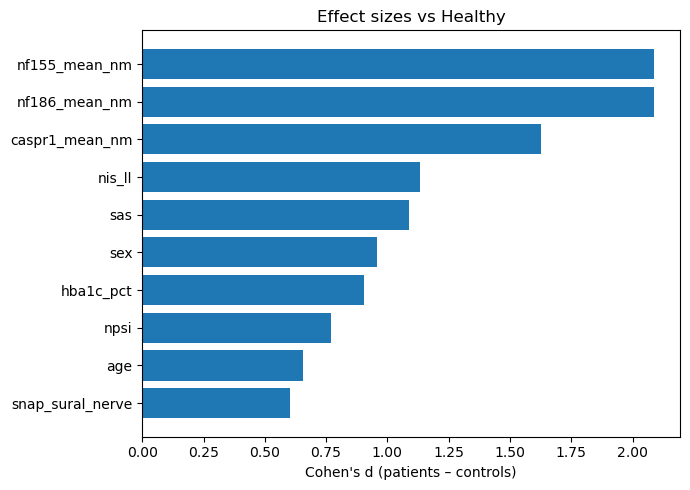

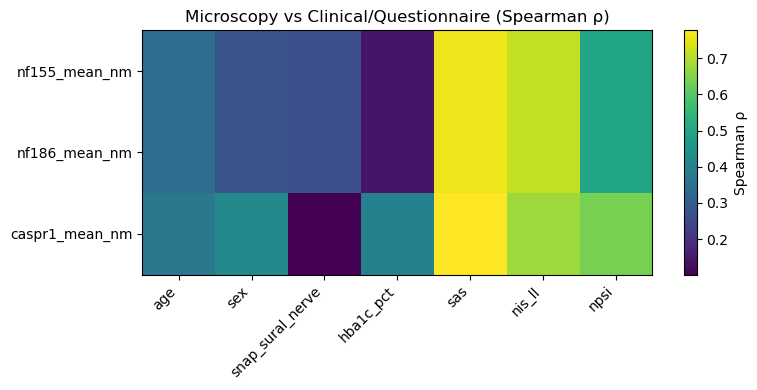

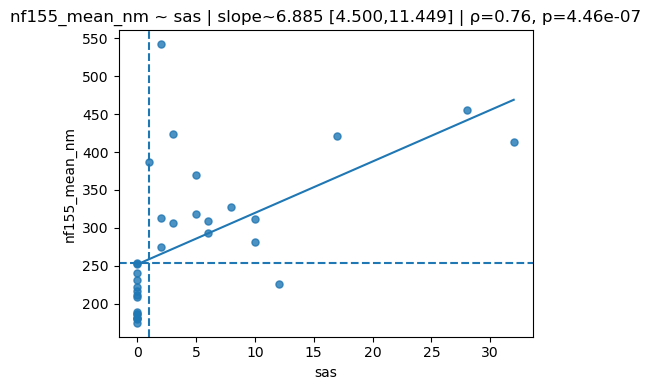

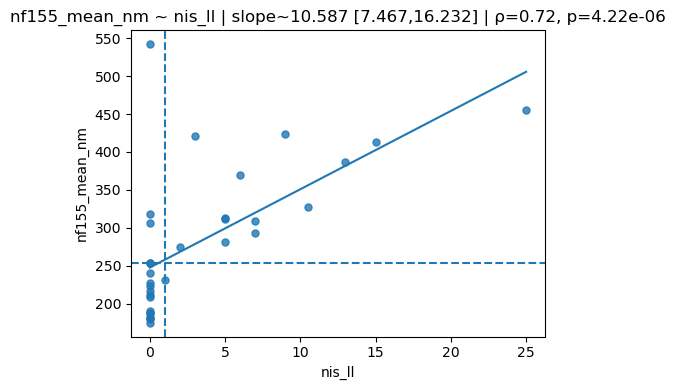

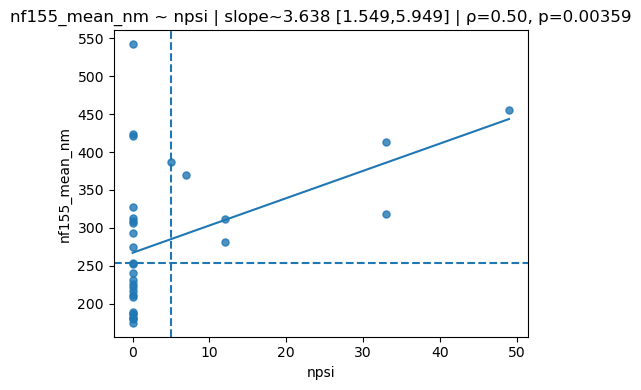

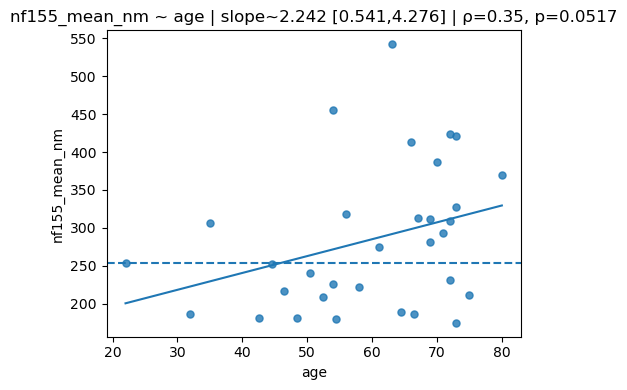

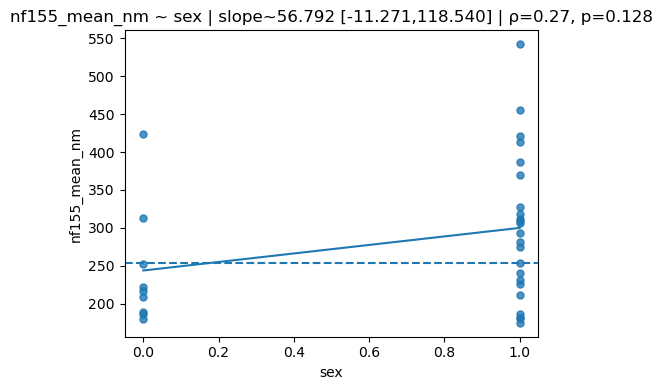

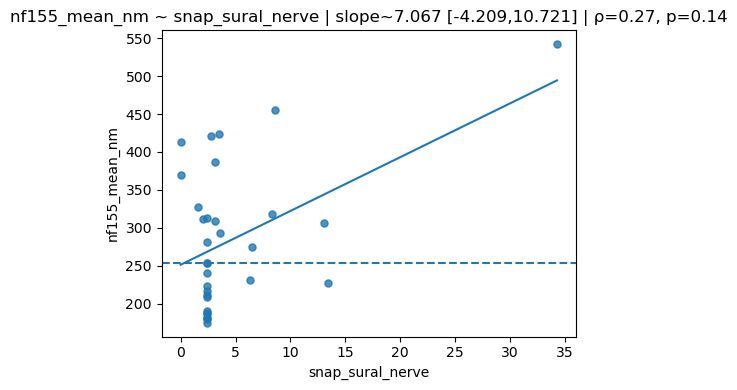

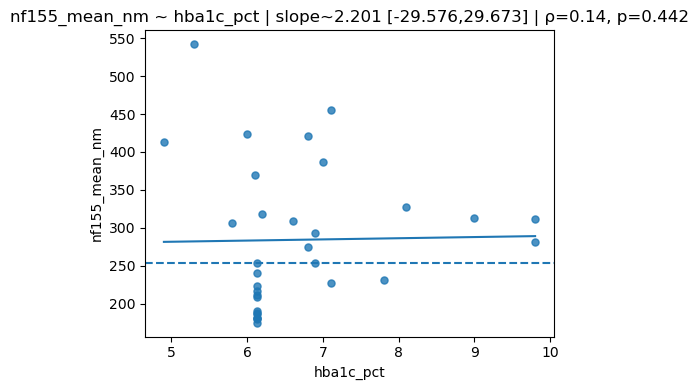

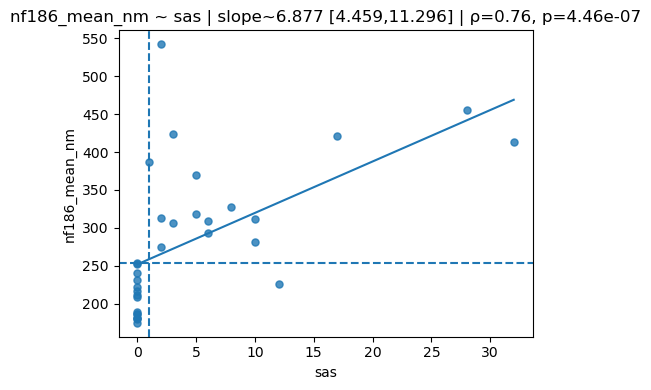

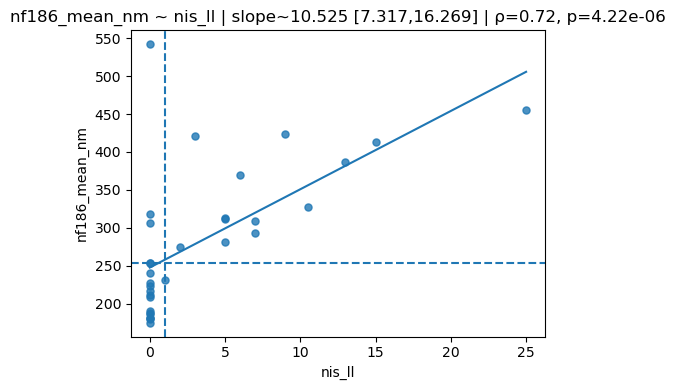

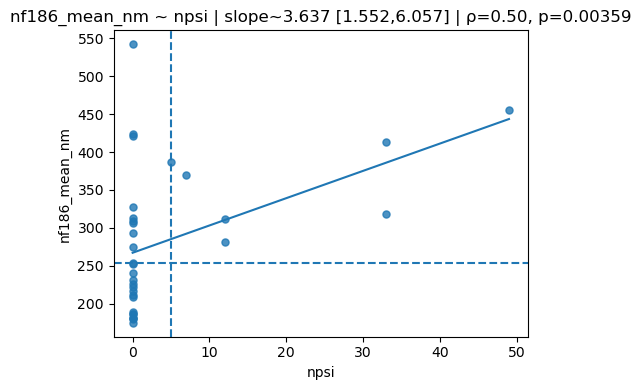

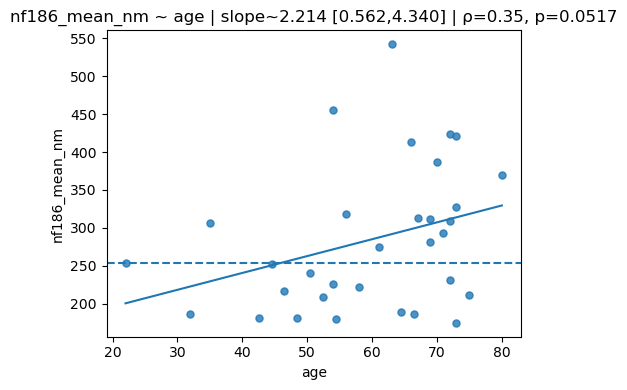

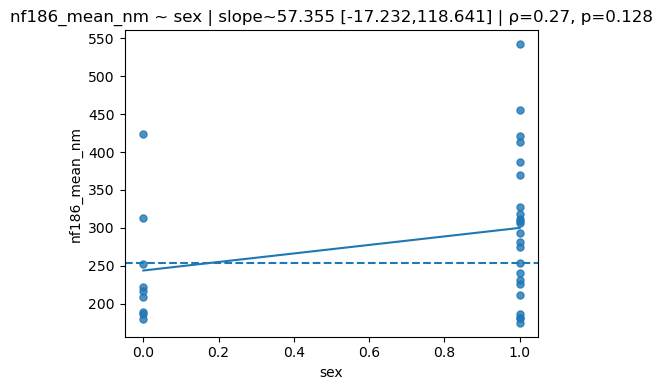

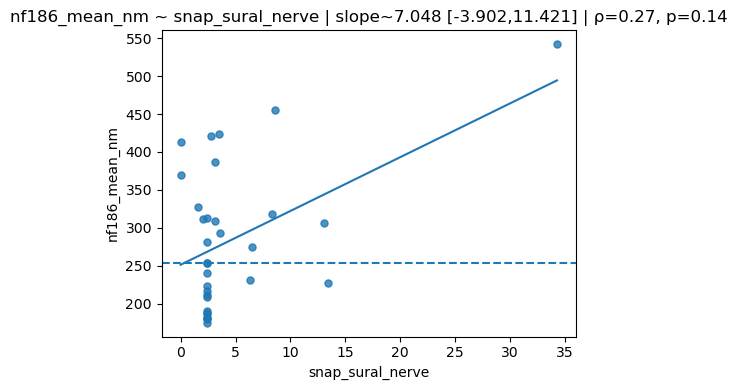

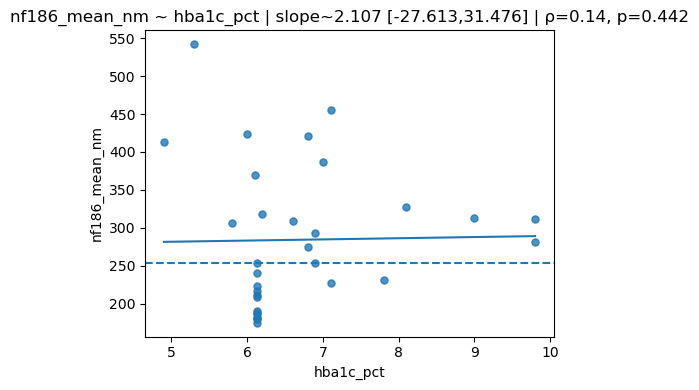

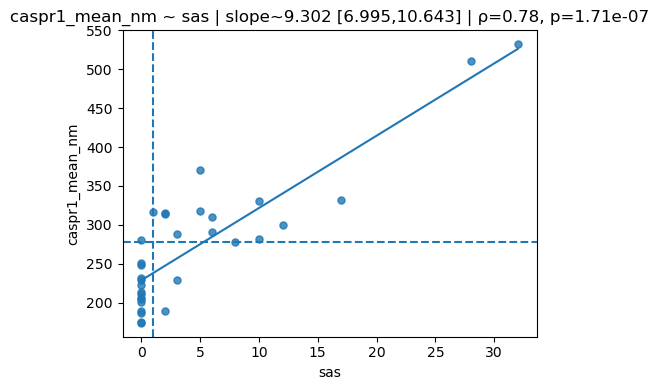

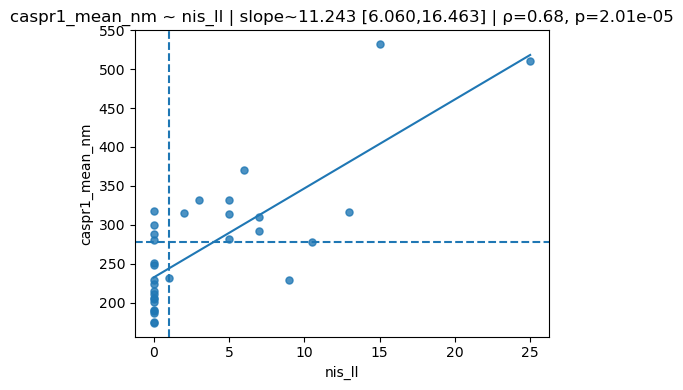

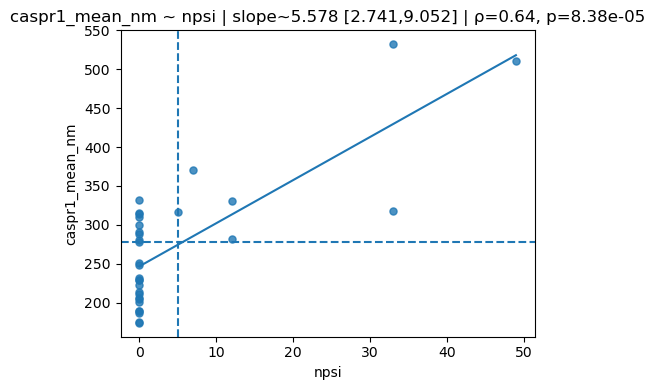

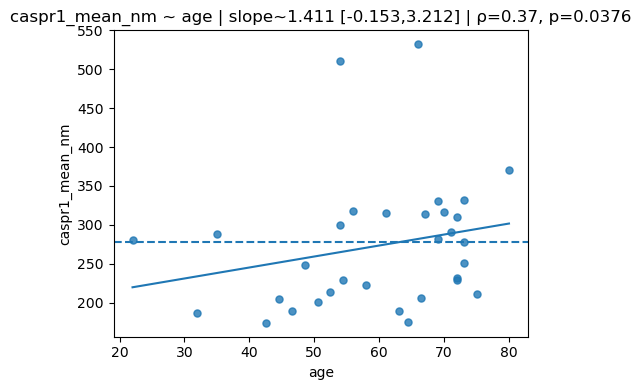

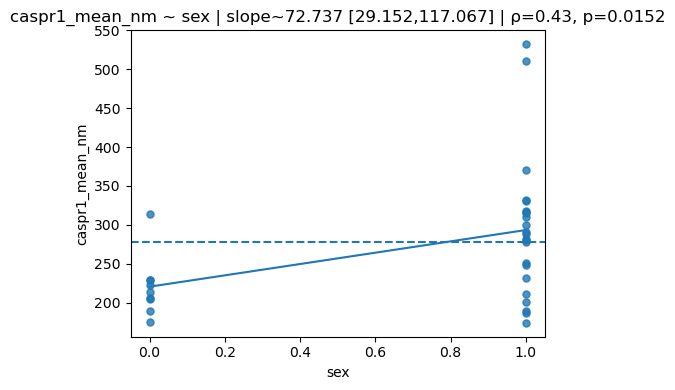

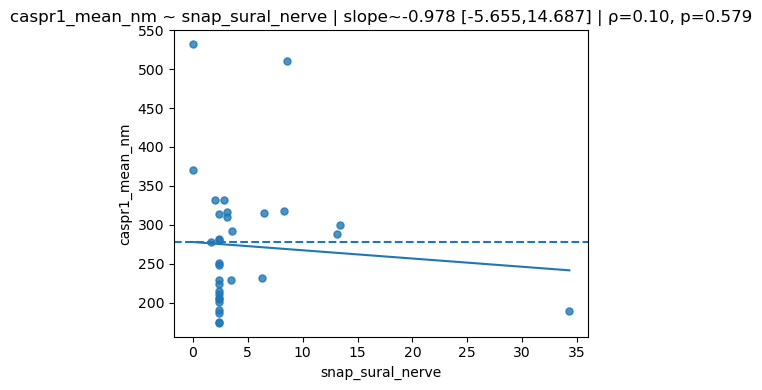

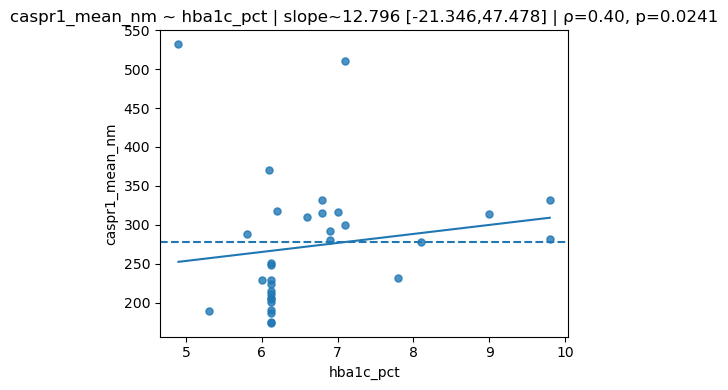

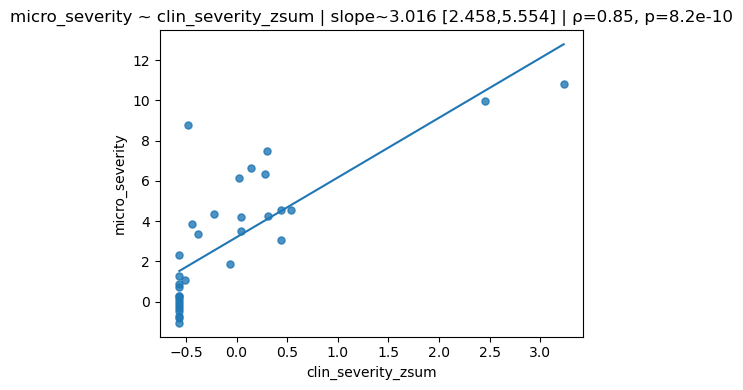

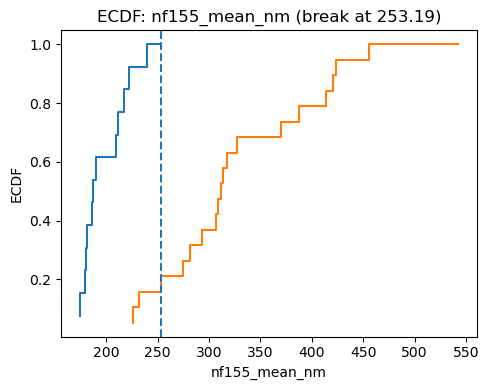

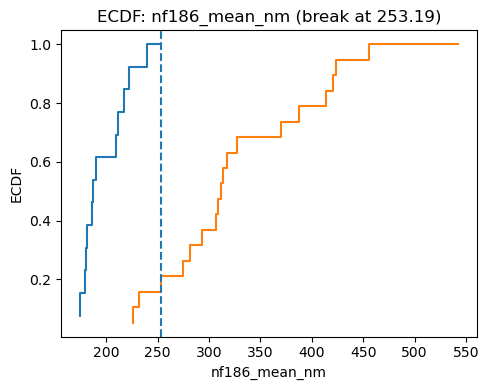

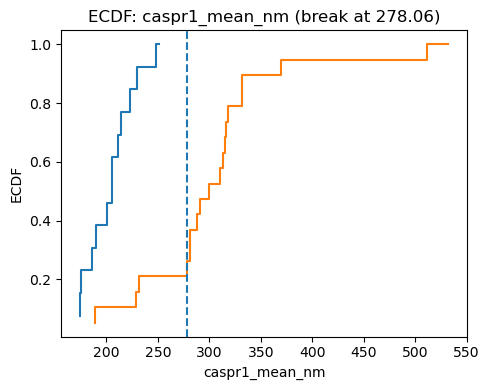

Saved outputs to: /storage/users/job37yv/Projects/Cardiomyopathy/analysis/effect-relations


In [151]:
# ============================================================
# Clinical ↔ Microscopy relationships + "periodicity break"
# ============================================================
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, roc_curve

OUT = Path("../analysis/effect-relations")
(OUT/"figs").mkdir(parents=True, exist_ok=True)

RNG = np.random.default_rng(42)
B = 2000
MIN_SAMPLES = 8

# --------------------------
# Column sets (edit as needed)
# --------------------------
MICRO = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]
CLINICAL = ["age","sex","snap_sural_nerve","hba1c_pct"]
QUESTION = ["sas","nis_ll","npsi"]
ALL_PRED = CLINICAL + QUESTION

# Label: Healthy (0) vs Patient (1/2)
df_rel = df.copy()
df_rel["is_patient"] = df_rel["group"].map({0:0,1:1,2:1}).astype("Int64")

# Treat instrument caps as missing
for c in MICRO:
    if c in df_rel.columns:
        df_rel.loc[df_rel[c] >= 600, c] = np.nan

# --------------------------
# Helper functions
# --------------------------
def cohen_d(x0, x1):
    x0, x1 = np.asarray(x0, float), np.asarray(x1, float)
    m0, m1 = np.nanmean(x0), np.nanmean(x1)
    s0, s1 = np.nanstd(x0, ddof=1), np.nanstd(x1, ddof=1)
    n0, n1 = np.sum(~np.isnan(x0)), np.sum(~np.isnan(x1))
    if n0<2 or n1<2: return np.nan
    sp = np.sqrt(((n0-1)*s0**2 + (n1-1)*s1**2) / (n0+n1-2))
    return (m1 - m0) / sp if sp>0 else np.nan

def cliffs_delta(x0, x1):
    x0, x1 = np.asarray(x0, float), np.asarray(x1, float)
    x0 = x0[~np.isnan(x0)]; x1 = x1[~np.isnan(x1)]
    if len(x0)==0 or len(x1)==0: return np.nan
    # efficient-ish via broadcasting chunked
    gt = 0; lt = 0
    for v in x0:
        gt += np.sum(v > x1)
        lt += np.sum(v < x1)
    N = len(x0)*len(x1)
    return (gt - lt) / N if N else np.nan

def boot_slope_ci(x, y, B=2000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    x = np.asarray(x, float); y = np.asarray(y, float)
    ok = ~(np.isnan(x)|np.isnan(y))
    x, y = x[ok], y[ok]
    if len(x) < MIN_SAMPLES or np.nanstd(x) == 0: 
        return np.nan, (np.nan, np.nan)
    idx = np.arange(len(x))
    slopes = []
    for _ in range(B):
        s = rng.choice(idx, size=len(idx), replace=True)
        xi, yi = x[s], y[s]
        if np.nanstd(xi)==0: slopes.append(np.nan); continue
        b1, b0 = np.polyfit(xi, yi, 1)
        slopes.append(b1)
    slopes = np.asarray(slopes, float)
    return float(np.nanmedian(slopes)), (float(np.nanpercentile(slopes,2.5)), float(np.nanpercentile(slopes,97.5)))

def boot_auc(y, x, B=2000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    y = np.asarray(y, int); x = np.asarray(x, float)
    i0, i1 = np.where(y==0)[0], np.where(y==1)[0]
    if len(i0)==0 or len(i1)==0: return np.nan, (np.nan, np.nan)
    vals = []
    for _ in range(B):
        s0 = rng.choice(i0, len(i0), True)
        s1 = rng.choice(i1, len(i1), True)
        xi = np.concatenate([x[s0], x[s1]])
        yi = np.concatenate([np.zeros_like(s0), np.ones_like(s1)])
        try: vals.append(roc_auc_score(yi, xi))
        except: vals.append(np.nan)
    vals = np.array(vals, float)
    return float(np.nanmedian(vals)), (float(np.nanpercentile(vals,2.5)), float(np.nanpercentile(vals,97.5)))

# --------------------------
# Composite microscopy severity (z vs controls)
# --------------------------
def micro_composite(df_):
    comp = pd.Series(np.nan, index=df_.index, dtype=float)
    zcols = []
    for mcol in MICRO:
        if mcol not in df_: continue
        ctrl = df_.loc[df_["is_patient"]==0, mcol].astype(float)
        mu, sd = np.nanmean(ctrl), np.nanstd(ctrl, ddof=1)
        z = (df_[mcol].astype(float) - mu) / sd if sd>0 else np.nan
        df_[f"{mcol}_z"] = z
        zcols.append(f"{mcol}_z")
    if zcols:
        comp = df_[zcols].mean(axis=1)
    return comp

df_rel["micro_severity"] = micro_composite(df_rel)

# Optional composite clinical severity (z of SAS/NIS-LL/NPSI)
clin_comp_cols = [c for c in ["sas","nis_ll","npsi"] if c in df_rel]
if clin_comp_cols:
    for c in clin_comp_cols:
        x = df_rel[c].astype(float)
        mu, sd = np.nanmean(x), np.nanstd(x, ddof=1)
        df_rel[f"{c}_z"] = (x - mu)/sd if sd>0 else np.nan
    df_rel["clin_severity_zsum"] = df_rel[[f"{c}_z" for c in clin_comp_cols]].mean(axis=1)

# --------------------------
# "Periodicity break" flags (edit thresholds if needed)
# --------------------------
BREAK_THR = {"nf155_mean_nm":253.19, "nf186_mean_nm":253.19, "caspr1_mean_nm":278.06}
for mcol, thr in BREAK_THR.items():
    if mcol in df_rel:
        df_rel[f"{mcol}_break"] = (df_rel[mcol].astype(float) >= thr).astype("Int64")

# --------------------------
# 1) Effect sizes (patients vs controls)
# --------------------------
eff_rows = []
for feat in ALL_PRED + MICRO:
    if feat not in df_rel: continue
    sub = df_rel[["is_patient", feat]].dropna()
    if len(sub) < MIN_SAMPLES or sub["is_patient"].nunique()<2: continue
    x0 = sub.loc[sub["is_patient"]==0, feat].astype(float)
    x1 = sub.loc[sub["is_patient"]==1, feat].astype(float)
    d = cohen_d(x0, x1)
    delta = cliffs_delta(x0, x1)
    # optional: univariate AUC (higher values -> more "patient" assumed)
    auc_med, (lo,hi) = boot_auc(sub["is_patient"], sub[feat], B=B, rng=RNG)
    eff_rows.append({"feature":feat, "n":len(sub), "cohen_d":d, "cliffs_delta":delta,
                     "AUC_boot":auc_med, "AUC_lo":lo, "AUC_hi":hi})
eff = pd.DataFrame(eff_rows).sort_values(["AUC_boot","cohen_d"], ascending=False)
eff.to_csv(OUT/"effect_sizes_vs_health.csv", index=False)

# Plot: effect-size bars (Cohen's d)
plt.figure(figsize=(7,5))
order = eff.sort_values("cohen_d", ascending=True)
plt.barh(order["feature"], order["cohen_d"])
plt.xlabel("Cohen's d (patients – controls)")
plt.title("Effect sizes vs Healthy")
plt.tight_layout(); plt.savefig(OUT/"figs/effect_sizes_cohen_d.png", dpi=300); plt.show()

# --------------------------
# 2) Correlation heatmap (microscopy vs clinical/questionnaire)
# --------------------------
heat = []
rows, cols = [], []
for mcol in MICRO:
    if mcol not in df_rel: continue
    row = []
    for feat in ALL_PRED:
        if feat not in df_rel: 
            row.append(np.nan); continue
        a = df_rel[[mcol, feat]].dropna()
        if len(a) < MIN_SAMPLES: 
            row.append(np.nan); continue
        rho, p = spearmanr(a[mcol].astype(float), a[feat].astype(float))
        row.append(rho)
    heat.append(row); rows.append(mcol)
cols = [f for f in ALL_PRED]
heat = np.array(heat, float)

plt.figure(figsize=(8,4))
im = plt.imshow(heat, aspect="auto", interpolation="nearest")
plt.xticks(ticks=np.arange(len(cols)), labels=cols, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(rows)), labels=rows)
plt.colorbar(im, label="Spearman ρ")
plt.title("Microscopy vs Clinical/Questionnaire (Spearman ρ)")
plt.tight_layout(); plt.savefig(OUT/"figs/heat_microscopy_vs_clinical.png", dpi=300); plt.show()

# --------------------------
# 3) Scatter + fit with cut lines & slope CIs
# --------------------------
def scatter_with_fit(df_, xcol, ycol, x_cut=None, y_cut=None, fname=None):
    m = df_[[xcol, ycol]].dropna()
    if len(m) < MIN_SAMPLES: return
    x = m[xcol].astype(float).values
    y = m[ycol].astype(float).values
    # OLS line + boot slope CI
    if np.nanstd(x)==0: return
    b1, b0 = np.polyfit(x, y, 1)
    s_med, (s_lo, s_hi) = boot_slope_ci(x, y, B=B, rng=RNG)
    rho, p = spearmanr(x, y)
    xp = np.linspace(x.min(), x.max(), 100)
    yp = b1*xp + b0

    plt.figure(figsize=(5,4))
    plt.scatter(x, y, s=26, alpha=0.8)
    plt.plot(xp, yp)
    if x_cut is not None: plt.axvline(x_cut, linestyle="--")
    if y_cut is not None: plt.axhline(y_cut, linestyle="--")
    ttl = f"{ycol} ~ {xcol} | slope~{s_med:.3f} [{s_lo:.3f},{s_hi:.3f}] | ρ={rho:.2f}, p={p:.3g}"
    plt.title(ttl)
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=300)
    plt.show()

# Key relationships (microscopy vs questionnaires/clinical)
for mcol in MICRO:
    for ccol in QUESTION + CLINICAL:
        if mcol in df_rel and ccol in df_rel:
            scatter_with_fit(
                df_rel, ccol, mcol,
                x_cut=(1.0 if ccol in ["sas","nis_ll"] else (5.0 if ccol=="npsi" else None)),
                y_cut=BREAK_THR.get(mcol, None),
                fname=OUT/"figs"/f"scatter_{mcol}_vs_{ccol}.png"
            )

# --------------------------
# 4) Composite severity ↔ clinical severity
# --------------------------
if "clin_severity_zsum" in df_rel:
    scatter_with_fit(
        df_rel, "clin_severity_zsum", "micro_severity",
        x_cut=None, y_cut=None,
        fname=OUT/"figs/scatter_composite_clin_vs_micro.png"
    )

# --------------------------
# 5) ECDFs with "break" thresholds
# --------------------------
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

for mcol in MICRO:
    if mcol not in df_rel: continue
    sub = df_rel[[mcol,"is_patient"]].dropna()
    if len(sub) < MIN_SAMPLES: continue
    xc, yc = ecdf(sub.loc[sub["is_patient"]==0, mcol].astype(float).values)
    xp, yp = ecdf(sub.loc[sub["is_patient"]==1, mcol].astype(float).values)
    plt.figure(figsize=(5,4))
    plt.step(xc, yc)
    plt.step(xp, yp)
    thr = BREAK_THR.get(mcol, None)
    if thr is not None: plt.axvline(thr, linestyle="--")
    plt.xlabel(mcol); plt.ylabel("ECDF")
    plt.title(f"ECDF: {mcol} (break at {thr if thr is not None else '—'})")
    plt.tight_layout(); plt.savefig(OUT/"figs"/f"ecdf_{mcol}.png", dpi=300); plt.show()

# --------------------------
# 6) Summaries for the manuscript
# --------------------------
# (a) break counts by group
br_rows = []
for mcol in MICRO:
    bflag = f"{mcol}_break"
    if bflag in df_rel:
        ct = pd.crosstab(df_rel["is_patient"], df_rel[bflag], dropna=False)
        br_rows.append({"microscopy":mcol,
                        "n_controls":int((df_rel["is_patient"]==0).sum()),
                        "n_patients":int((df_rel["is_patient"]==1).sum()),
                        "controls_break":int(ct.loc[0,1] if (0 in ct.index and 1 in ct.columns) else 0),
                        "patients_break":int(ct.loc[1,1] if (1 in ct.index and 1 in ct.columns) else 0)})
br = pd.DataFrame(br_rows)
br.to_csv(OUT/"break_counts_by_group.csv", index=False)

# (b) Correlation table with p-values
corr_rows = []
for mcol in MICRO:
    if mcol not in df_rel: continue
    for feat in ALL_PRED:
        if feat not in df_rel: continue
        a = df_rel[[mcol, feat]].dropna()
        if len(a) < MIN_SAMPLES: continue
        rho, p = spearmanr(a[mcol].astype(float), a[feat].astype(float))
        corr_rows.append({"microscopy":mcol, "feature":feat, "n":len(a), "rho":rho, "p":p})
corr = pd.DataFrame(corr_rows).sort_values(["microscopy","rho"], ascending=[True,False])
corr.to_csv(OUT/"spearman_micro_vs_clinical.csv", index=False)

print(f"Saved outputs to: {OUT.resolve()}")
